In [ ]:
import joblib
import numpy as np
import pandas as pd
import os
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier
from itertools import product
from numpy.linalg import norm
from scipy import stats
from scipy.optimize import differential_evolution
from scipy.stats import pearsonr
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, BaggingClassifier)
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_recall_curve, auc, roc_curve, brier_score_loss, precision_score,
                             recall_score, accuracy_score, roc_auc_score, classification_report, confusion_matrix)
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, QuantileTransformer, PowerTransformer, 
                                   StandardScaler, MinMaxScaler, KBinsDiscretizer, FunctionTransformer, 
                                   PolynomialFeatures)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import set_config
set_config(display='diagram')
# Ignore warnings
import warnings
warnings.filterwarnings('ignore');

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import seaborn as sns
sns.set_palette(sns.color_palette('bright', 22))
sns.set_style("darkgrid")
%matplotlib inline

# Data path
train_set_path = 'dataset/adult_test.csv'
test_set_path = 'dataset/adult_data.csv'

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dip_images"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
# create train and test DataFrame by passing the path to the data, names of the columns 
# (got from original data source), and transform different notation of missing values into standard "N/A" value
column_names = [
    'Age', 'Work Class', 'Final Weight', 'Education', 'Education Number',
    'Marital Status', 'Occupation','Relationship', 'Race', 'Sex', 
    'Capital Gain', 'Capital Loss', 'Hours per Week', 'Country', 'Income'
]
na_values = ['?', ' ?', '? ', ' 99999']

# load the data
def get_data(path, name_col=column_names, na_val=na_values, skiprows=[]):
    data = pd.read_csv(path, names=name_col, na_values=na_val, skiprows=skiprows)
    return data

train = get_data(path=train_set_path, 
                 name_col=column_names, 
                 na_val=na_values)
test = get_data(path=test_set_path, 
                name_col=column_names, 
                na_val=na_values)

In [ ]:
train.sample(10)

In [17]:
test.head(5)

Age  Work Class  Final Weight      Education  \
0  |1x3 Cross validator         NaN           NaN            NaN   
1                    25     Private      226802.0           11th   
2                    38     Private       89814.0        HS-grad   
3                    28   Local-gov      336951.0     Assoc-acdm   
4                    44     Private      160323.0   Some-college   

   Education Number       Marital Status          Occupation Relationship  \
0               NaN                  NaN                 NaN          NaN   
1               7.0        Never-married   Machine-op-inspct    Own-child   
2               9.0   Married-civ-spouse     Farming-fishing      Husband   
3              12.0   Married-civ-spouse     Protective-serv      Husband   
4              10.0   Married-civ-spouse   Machine-op-inspct      Husband   

     Race    Sex  Capital Gain  Capital Loss  Hours per Week         Country  \
0     NaN    NaN           NaN           NaN             NaN             NaN   
1   Black   Male           0.0           0.0            40.0   United-States   
2   White   Male           0.0           0.0            50.0   United-States   
3   White   Male           0.0           0.0            40.0   United-States   
4   Black   Male        7688.0           0.0            40.0   United-States   

    Income  
0      NaN  
1   <=50K.  
2   <=50K.  
3    >50K.  
4    >50K.

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age                 32561 non-null int64
Work Class          30725 non-null object
Final Weight        32561 non-null int64
Education           32561 non-null object
Education Number    32561 non-null int64
Marital Status      32561 non-null object
Occupation          30718 non-null object
Relationship        32561 non-null object
Race                32561 non-null object
Sex                 32561 non-null object
Capital Gain        32402 non-null float64
Capital Loss        32561 non-null int64
Hours per Week      32561 non-null int64
Country             31978 non-null object
Income              32561 non-null object
dtypes: float64(1), int64(5), object(9)
memory usage: 3.7+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16282 entries, 0 to 16281
Data columns (total 15 columns):
Age                 16282 non-null object
Work Class          15318 non-null object
Final Weight        16281 non-null float64
Education           16281 non-null object
Education Number    16281 non-null float64
Marital Status      16281 non-null object
Occupation          15315 non-null object
Relationship        16281 non-null object
Race                16281 non-null object
Sex                 16281 non-null object
Capital Gain        16281 non-null float64
Capital Loss        16281 non-null float64
Hours per Week      16281 non-null float64
Country             16007 non-null object
Income              16281 non-null object
dtypes: float64(5), object(10)
memory usage: 1.9+ MB


In [16]:
striped = (
    train
    .select_dtypes(exclude=['int', 'float'])
    .applymap(lambda x: str(x).strip(" "))
    .replace('nan', np.nan))
train.update(striped)

In [17]:
train.columns = train.columns.str.lower().str.replace(' ', '_')

In [18]:
# duplicates removing, index reassignment
train.drop_duplicates(inplace=True)
train.reset_index(drop=True, inplace=True)

In [19]:
# encoding "0/1"
train['income'] = LabelEncoder().fit_transform(train['income'])

In [44]:
# full data examination
from pandas_profiling import ProfileReport
profile = ProfileReport(train, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_notebook_iframe()

Preliminary data examination results by categories (data type, noise(missed/irrelevant data), relevance to task, distribution type, corelation with other features) - theoretical transformations:
 - "age" (numerical, -, +, gamma, -) - normality transformations (log/box-cox/yeohnson) / discretization
 - "capital_gain" (numerical, zero/extreme values, exponential, income) - merge with capital_loss + normality transformations 
 - "capital_loss" (numerical, zero values, +, exponential, income) - merge with capital_gain + normality transformations 
 - "country"(categorical, missed values, +, categorical, income) - missing data imputation
 - "education" (categorical, -, +, categorical, education_number/income) - merge with education_number
 - "education_number" (numerical, -, +, min-extreme, education/income) - merge with education
 - "final_weight" (numerical, -, ?, exponential, -)
 - "hours_per_week" (numerical, -, +, gamma, income) - normality transformations (log/box-cox/yeohnson) / discretization 
 - "income" (numerical (target feature), -, +, binomial, +)
 - "marital_status" (categorical, -, +, categorical, income) - encoding
 - "occupation" (categorical, missed values, +, categorical, income) - missing data imputation
 - "race" (categorical, -, +, categorical, income) - encoding
 - "relationship" (categorical, -, +, categorical, income) - encoding
 - "sex" (categorical, -, +, categorical, income) - encoding
 - "work_class" (categorical, missed values, +, categorical, income) - missing data imputation

# Data Preprocessing (transformations + functions for automation of validation process)

In [29]:
trc = train.copy()
data = pd.DataFrame()

Saving figure hist_all_vars


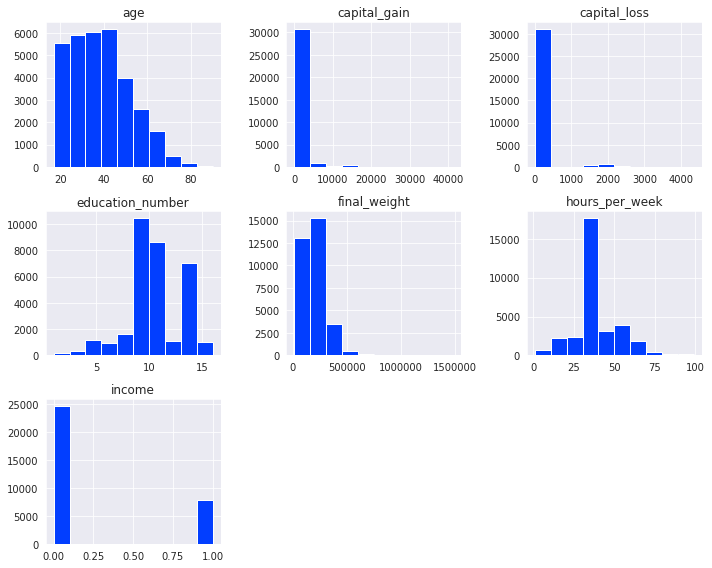

In [56]:
# histograms of the variables
train.hist(figsize=(10, 8))
save_fig('hist_all_vars')
plt.show()

In [57]:
# missed data
train.isna().sum()

age                    0
work_class          1836
final_weight           0
education              0
education_number       0
marital_status         0
occupation          1843
relationship           0
race                   0
sex                    0
capital_gain         159
capital_loss           0
hours_per_week         0
country              582
income                 0
dtype: int64

### Income

There are two class values ‘>50K‘ and ‘<=50K‘. The classes are imbalanced, with a skew toward the ‘<=50K‘ class label. Majority class: 75.9074%, minority class: 24.0926%. Given that the class imbalance is not severe and that both class labels are equally important, it is common to use classification accuracy or classification error to report model performance on this dataset.

In [59]:
train['income'].value_counts(normalize=True)

0    0.759074
1    0.240926
Name: income, dtype: float64

### Age

Saving figure age_distribution


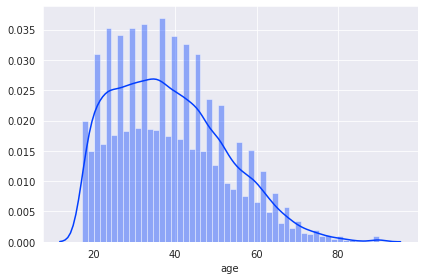

In [81]:
# distribution
sns.distplot(train['age'])
save_fig('age_distribution')

Saving figure age_income


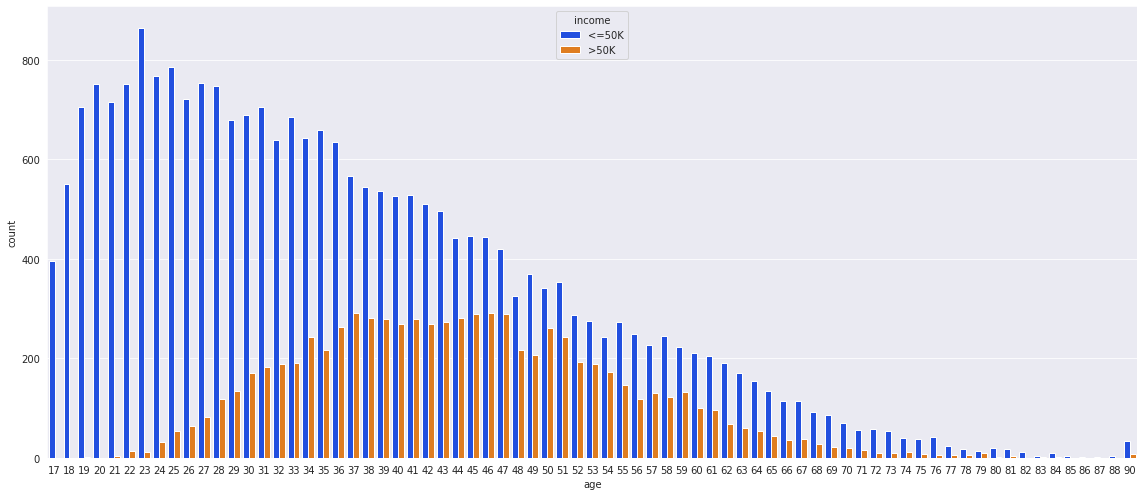

In [419]:
plt.subplots(figsize=(16, 7))
sns.countplot(x='age', hue='income', data=train)
save_fig('age_income')

Saving figure age_norm_1


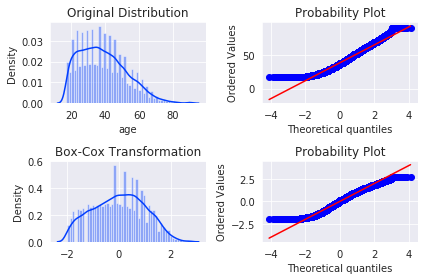

Saving figure age_norm_2


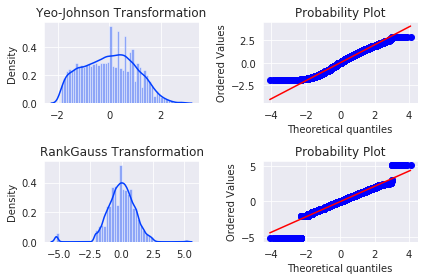

In [30]:
f = plt.figure(tight_layout=True)

ax1 = f.add_subplot(221)
ax1.title.set_text('Original Distribution')
res = sns.distplot(train['age'])
ax2 = f.add_subplot(222)
res = stats.probplot(train['age'], plot=plt)

# box-cox transformation 
bc_trans = PowerTransformer(method='box-cox')
data_bc = bc_trans.fit_transform(train[['age']])

ax3 = f.add_subplot(223)
ax3.title.set_text('Box-Cox Transformation')
res = sns.distplot(data_bc.ravel())
ax4 = f.add_subplot(224)
res = stats.probplot(data_bc.ravel(), plot=plt)
save_fig('age_norm_1')
plt.show()

f2 = plt.figure(tight_layout=True)

# Yeo-Johnson transformation 
# Sometimes a lift in performance can be achieved by first standardizing the raw dataset 
# prior to performing a Yeo-Johnson transform. (just to keep in mind)
sc = StandardScaler()
yj_trans = PowerTransformer(method='yeo-johnson')
scaled = sc.fit_transform(train[['age']])
data_yj = yj_trans.fit_transform(scaled)

ax1 = f2.add_subplot(221)
ax1.title.set_text('Yeo-Johnson Transformation')
res = sns.distplot(data_yj.ravel())
ax2 = f2.add_subplot(222)
res = stats.probplot(data_yj.ravel(), plot=plt)

# RankGauss transformation
transformer = QuantileTransformer(n_quantiles=100, random_state=1111, output_distribution='normal')
data = transformer.fit_transform(train[['age']])

ax3 = f2.add_subplot(223)
ax3.title.set_text('RankGauss Transformation')
res = sns.distplot(data.ravel())
ax4 = f2.add_subplot(224)
res = stats.probplot(data.ravel(), plot=plt)

save_fig('age_norm_2')
plt.show()

Saving figure age_kbins


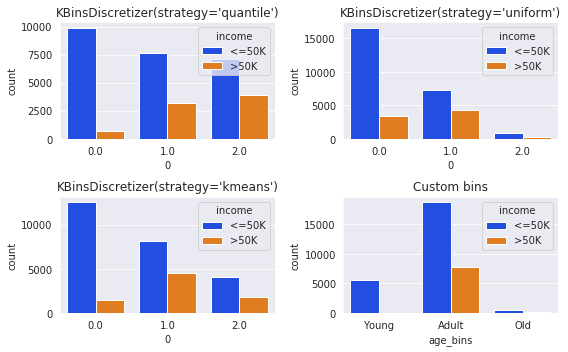

In [31]:
# 3 different types of discretization, quality of which should be checked through cross-validation
f = plt.figure(figsize=(8,5), tight_layout=True)

kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
data_trans = kbins.fit_transform(train[['age']])
ax1 = f.add_subplot(221)
ax1.title.set_text("KBinsDiscretizer(strategy='quantile')")
res = sns.countplot(x=pd.DataFrame(data_trans).iloc[:, 0], hue='income', data=train)

kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
data_trans = kbins.fit_transform(train[['age']])
ax2 = f.add_subplot(222)
ax2.title.set_text("KBinsDiscretizer(strategy='uniform')")
res = sns.countplot(x=pd.DataFrame(data_trans).iloc[:, 0], hue='income', data=train)

kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
data_trans = kbins.fit_transform(train[['age']])
ax3 = f.add_subplot(223)
ax3.title.set_text("KBinsDiscretizer(strategy='kmeans')")
res = sns.countplot(x=pd.DataFrame(data_trans).iloc[:, 0], hue='income', data=train)

# group by age
trc['age_bins'] = pd.cut(train['age'], bins=[0, 24, 70, 90], labels=['Young', 'Adult', 'Old'])
ax4 = f.add_subplot(224)
ax4.title.set_text("Custom bins")
res = sns.countplot(x='age_bins', hue='income', data=trc)

save_fig('age_kbins')
plt.show()

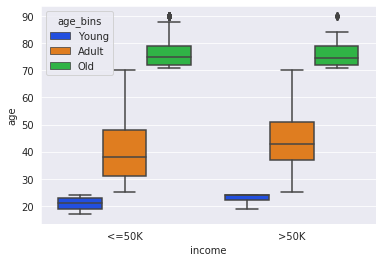

In [19]:
sns.boxplot(y='age', x='income', hue='age_bins', data=trc)

### capital_gain & capital_loss

Saving figure capital_g_d


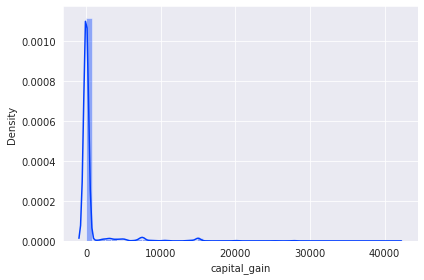

In [22]:
sns.distplot(train['capital_gain'])
save_fig('capital_g_d')

Saving figure cap_g_income


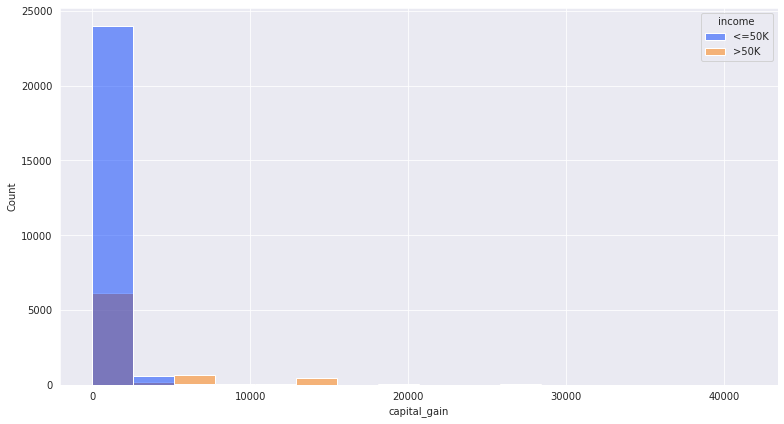

In [23]:
plt.subplots(figsize=(11, 6))
sns.histplot(x='capital_gain', hue='income', data=train)
save_fig('cap_g_income')

Saving figure capital_l_d


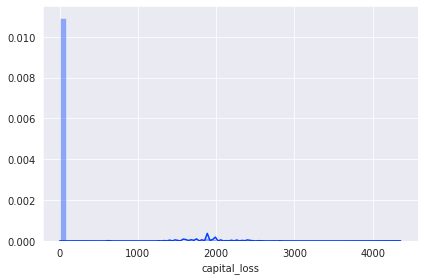

In [32]:
sns.distplot(train['capital_loss'])
save_fig('capital_l_d')

Saving figure cap_l_income


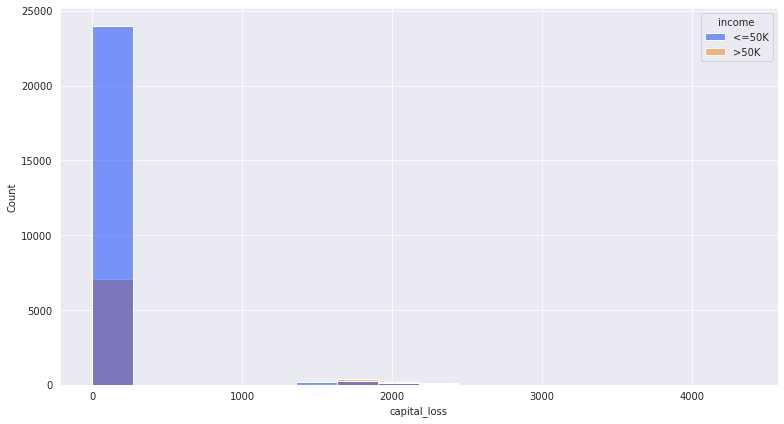

In [13]:
plt.subplots(figsize=(11, 6))
sns.histplot(x='capital_loss', hue='income', data=train)
save_fig('cap_l_income')

Saving figure capital_differ_distribution_missed


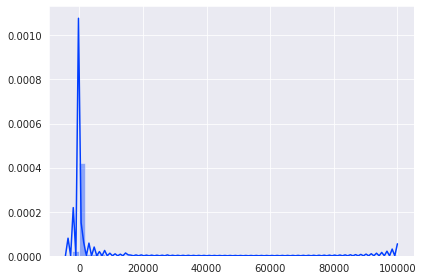

In [83]:
# a new vatiable for representing a difference between 'capital_gain' and 'capital_loss'
sns.distplot(train['capital_gain'] - train['capital_loss'])
save_fig('capital_differ_distribution_missed')

Saving figure cap_d_income


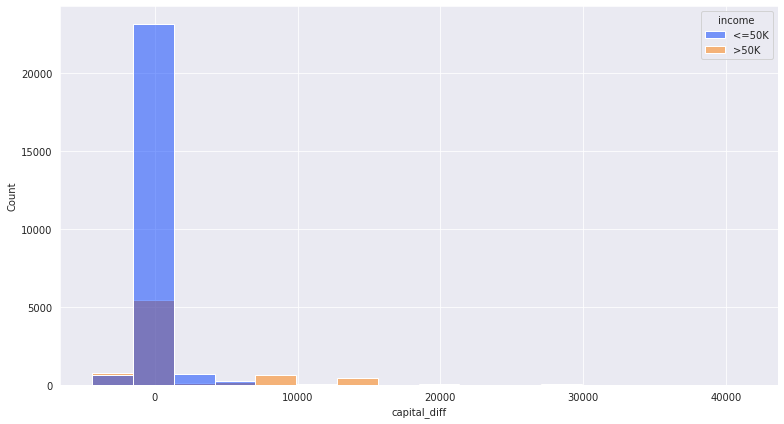

In [32]:
plt.subplots(figsize=(11, 6))
trc['capital_diff'] = train['capital_gain'] - train['capital_loss']
sns.histplot(x='capital_diff', hue='income', data=trc)
save_fig('cap_d_income')

In [62]:
# discard lossed values
missed = train['capital_gain'] == 99999.0
dat = train.loc[~missed, ['income', 'capital_gain', 'capital_loss']]
dat['capital_differ'] = dat['capital_gain'] - dat['capital_loss']
dat.reset_index(inplace=True)

Saving figure capital_differ_distribution_missed_trunc


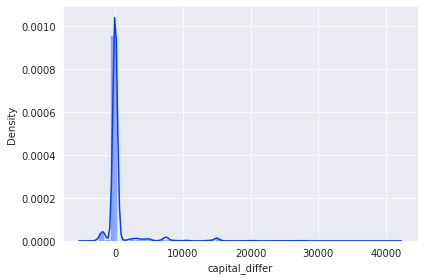

In [63]:
sns.distplot(dat['capital_differ'])
save_fig('capital_differ_distribution_missed_trunc')

Saving figure capital_differ_normal


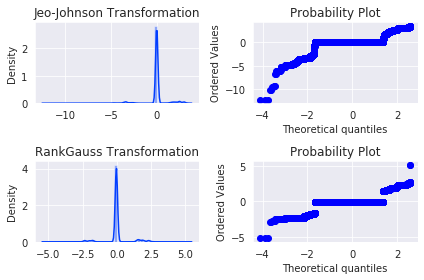

In [64]:
# box-cox transformation doesn't apply here because of negative values
f2 = plt.figure(tight_layout=True)

sc = StandardScaler()
yj_trans = PowerTransformer(method='yeo-johnson')
scaled = sc.fit_transform(dat[['capital_differ']])
data_yj = yj_trans.fit_transform(scaled)

ax1 = f2.add_subplot(221)
ax1.title.set_text("Jeo-Johnson Transformation")
res = sns.distplot(data_yj.ravel())
ax2 = f2.add_subplot(222)
res = stats.probplot(data_yj.ravel(), plot=plt)

# RankGauss transformation
transformer = QuantileTransformer(n_quantiles=100, random_state=1111, output_distribution='normal')
data = transformer.fit_transform(dat[['capital_differ']])

ax3 = f2.add_subplot(223)
ax3.title.set_text("RankGauss Transformation")
res = sns.distplot(data.ravel())
ax4 = f2.add_subplot(224)
res = stats.probplot(data.ravel(), plot=plt)

save_fig('capital_differ_normal')
plt.show()

Saving figure capital_differ_kbins


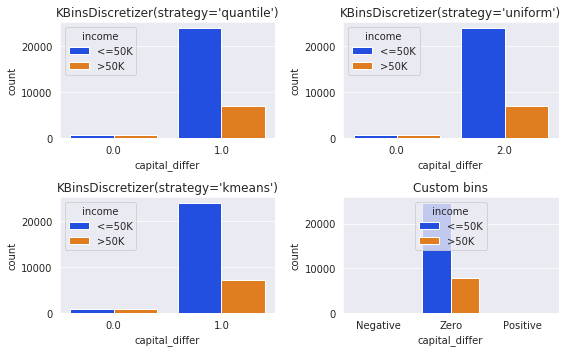

In [77]:
# binning may also be applied
f = plt.figure(figsize=(8,5), tight_layout=True)

kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
data_trans = kbins.fit_transform(dat[['capital_differ']])
dat['capital_differ'] = data_trans
ax1 = f.add_subplot(221)
ax1.title.set_text("KBinsDiscretizer(strategy='quantile')")
res = sns.countplot(x='capital_differ', hue='income', data=dat)

kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
data_trans = kbins.fit_transform(dat[['capital_differ']])
dat['capital_differ'] = data_trans
ax2 = f.add_subplot(222)
ax2.title.set_text("KBinsDiscretizer(strategy='uniform')")
res = sns.countplot(x='capital_differ', hue='income', data=dat)

kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
data_trans = kbins.fit_transform(dat[['capital_differ']])
dat['capital_differ'] = data_trans
ax3 = f.add_subplot(223)
ax3.title.set_text("KBinsDiscretizer(strategy='kmeans')")
res = sns.countplot(x='capital_differ', hue='income', data=dat)

# group by capital differencies
a = pd.cut(dat['capital_differ'], bins=[-4356, -1, 1, 41310], labels=['Negative', 'Zero', 'Positive'])
ax4 = f.add_subplot(224)
ax4.title.set_text("Custom bins")
res = sns.countplot(x=a, hue='income', data=dat)

save_fig('capital_differ_kbins')
plt.show()

In [76]:
dat['capital_differ'] = np.nan_to_num(dat['capital_differ'])

### work_class & occupation

In [161]:
# column "work_class"
# 1836 values are missed; instead of deletion we should try imputation methods
train['work_class'].value_counts(dropna=False)

Private             22673
Self-emp-not-inc     2540
Local-gov            2093
NaN                  1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: work_class, dtype: int64

Saving figure workclass_income


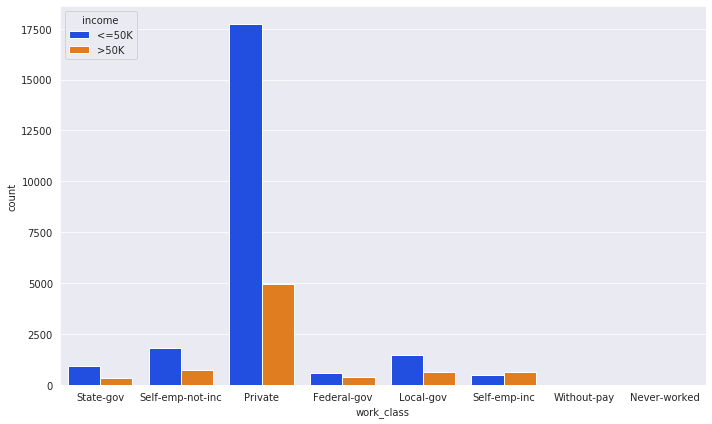

In [27]:
plt.subplots(figsize=(10, 6))
sns.countplot(x='work_class', hue='income', data=train)
save_fig('workclass_income')

In [154]:
# 1843 values missed
X_train['occupation'].value_counts(dropna=False)

Prof-specialty       4136
Craft-repair         4094
Exec-managerial      4065
Adm-clerical         3768
Sales                3650
Other-service        3291
Machine-op-inspct    2000
NaN                  1836
Transport-moving     1597
Handlers-cleaners    1369
Farming-fishing       992
Tech-support          927
Protective-serv       649
Priv-house-serv       147
Armed-Forces            9
Unemployed              7
Name: occupation, dtype: int64

Saving figure occupation_income


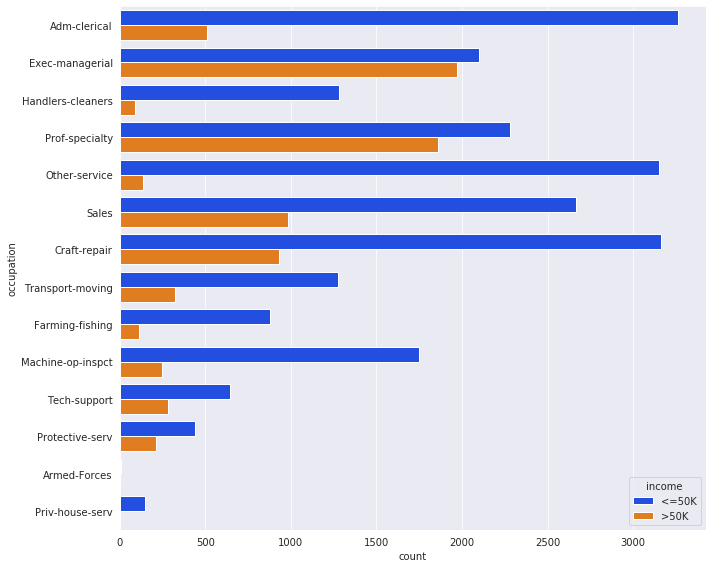

In [32]:
plt.subplots(figsize=(10, 8))
sns.countplot(y='occupation', hue='income', data=train)
save_fig('occupation_income')

we have to investigate wether missed data of this columns is actually missed into the same rows and what is the difference of missing between them 

In [90]:
# replace NaN values with some arbitrary value in order to facilitate access (work with dataset copy)
trc[['occupation', 'work_class']] = train[['occupation', 'work_class']].fillna('Unk')

Saving figure occup_work_class_dist


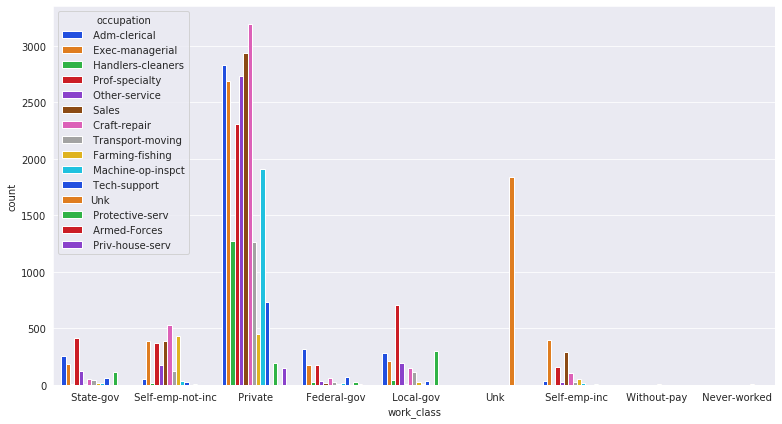

In [92]:
# let`s have a look on difference between columns 'occupation' and 'work_class'
# as we can see almost all missed data distributed among the same rows 
unk = (trc['occupation'].str.contains('Unk') | trc['work_class'].str.contains('Unk'))
missed = trc.loc[unk, ['occupation', 'work_class', 'income']]

plt.subplots(figsize=(11, 6))
sns.countplot(x='work_class', hue='occupation', data=trc)
save_fig('occup_work_class_dist')

In [93]:
# here are those extra 7 missed values for 'occupation'; 
# recall that there is only 7 entries for class 'Never_worked' of the 'work_class' column, 
# so it is clear why for this class there is no 'occupation' value, it doesn't exist and we should create it.
both_missed = (missed['work_class'].str.contains('Unk') & missed['occupation'].str.contains('Unk'))
missed.loc[~both_missed]

occupation     work_class  income
5359         Unk   Never-worked     NaN
10842        Unk   Never-worked     NaN
14767        Unk   Never-worked     NaN
20328        Unk   Never-worked     NaN
23217        Unk   Never-worked     NaN
32281        Unk   Never-worked     NaN
32291        Unk   Never-worked     NaN

In [94]:
filt = (train['work_class'] == 'Never-worked')
train.loc[filt] = train.loc[filt].fillna('Unemployed')

Saving figure occupation_dist


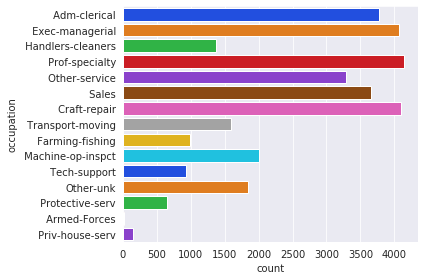

In [96]:
train['occupation'].fillna('Other-unk', inplace=True)
sns.countplot(y='occupation', data=train)
save_fig('occupation_dist')

Saving figure work_class_dist


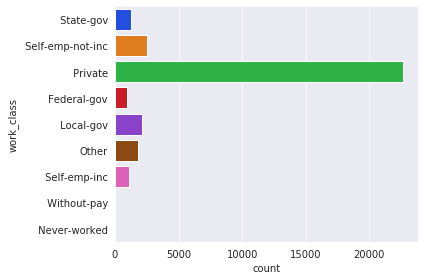

In [97]:
train['work_class'].fillna('Other', inplace=True)
sns.countplot(y='work_class', data=train)
save_fig('work_class_dist')

### country

Saving figure country_income


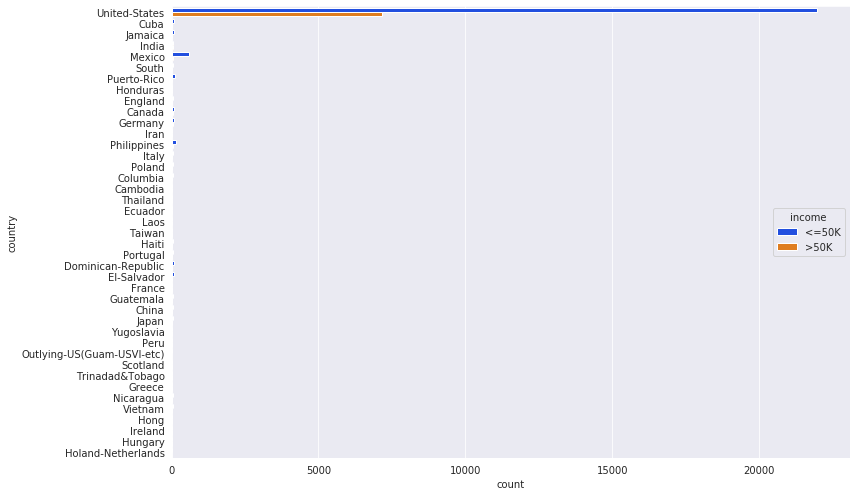

In [33]:
plt.subplots(figsize=(12, 7))
sns.countplot(y='country', hue='income', data=train)
save_fig('country_income')

In [99]:
train['country'].fillna('Other', inplace=True)

In [100]:
train['country'].value_counts(normalize=True)[0:5]

 United-States    0.895995
 Mexico           0.019639
Other             0.017887
 Philippines      0.006085
 Germany          0.004211
Name: country, dtype: float64

### final_weight

Saving figure final_weight_dist


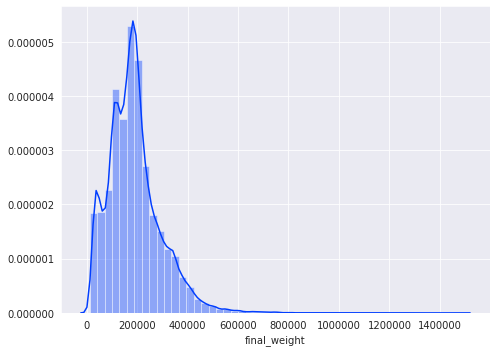

In [103]:
# has zero corelation and should be ckecked during Feature Selection
plt.subplots(figsize=(7, 5))
sns.distplot(train['final_weight'])
save_fig('final_weight_dist')

Saving figure final_weight_income


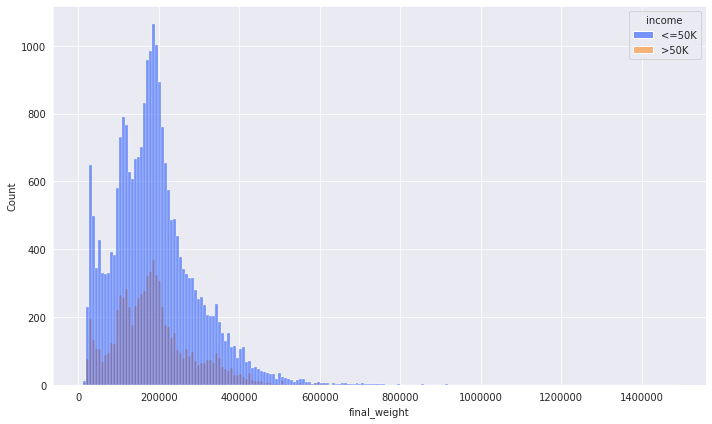

In [34]:
plt.subplots(figsize=(10, 6))
sns.histplot(x='final_weight', hue='income', data=train)
save_fig('final_weight_income')

### hours_per_week

Saving figure hours_per_week_dist


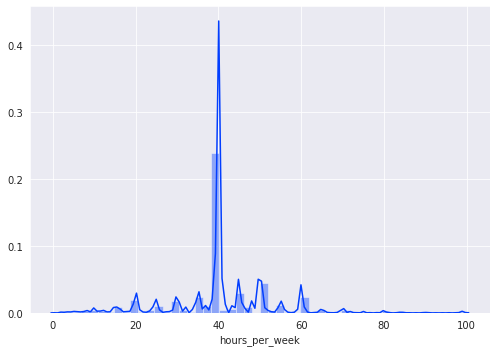

In [104]:
plt.subplots(figsize=(7, 5))
sns.distplot(train['hours_per_week'])
save_fig('hours_per_week_dist')

Saving figure hours_per_week_income


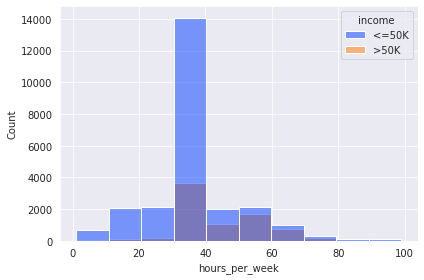

In [82]:
sns.histplot(x='hours_per_week', hue='income', bins=10, data=train)
save_fig('hours_per_week_income')

Saving figure hours_per_week_norm_1


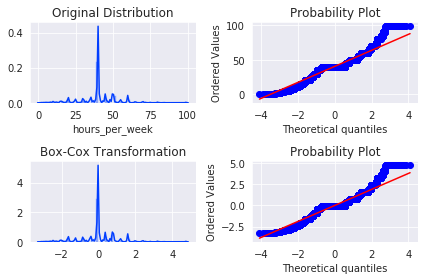

Saving figure hours_per_week_norm_2


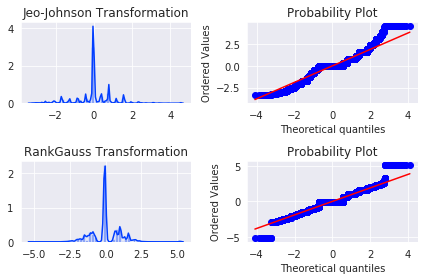

In [111]:
f = plt.figure(tight_layout=True)

ax1 = f.add_subplot(221)
ax1.title.set_text("Original Distribution")
res = sns.distplot(train['hours_per_week'])
ax2 = f.add_subplot(222)
res = stats.probplot(train['hours_per_week'], plot=plt)

# box-cox transformation 
bc_trans = PowerTransformer(method='box-cox')
data_bc = bc_trans.fit_transform(train[['hours_per_week']])

ax3 = f.add_subplot(223)
ax3.title.set_text("Box-Cox Transformation")
res = sns.distplot(data_bc.ravel())
ax4 = f.add_subplot(224)
res = stats.probplot(data_bc.ravel(), plot=plt)

save_fig('hours_per_week_norm_1')
plt.show()

f2 = plt.figure(tight_layout=True)

# Yeo-Johnson transformation 
# Sometimes a lift in performance can be achieved by first standardizing the raw dataset 
# prior to performing a Yeo-Johnson transform. (just to keep in mind)
sc = StandardScaler()
yj_trans = PowerTransformer(method='yeo-johnson')
scaled = sc.fit_transform(train[['hours_per_week']])
data_yj = yj_trans.fit_transform(scaled)

ax1 = f2.add_subplot(221)
ax1.title.set_text("Jeo-Johnson Transformation")
res = sns.distplot(data_yj.ravel())
ax2 = f2.add_subplot(222)
res = stats.probplot(data_yj.ravel(), plot=plt)

# RankGauss transformation
transformer = QuantileTransformer(n_quantiles=100, random_state=1111, output_distribution='normal')
data = transformer.fit_transform(train[['hours_per_week']])

ax3 = f2.add_subplot(223)
ax3.title.set_text("RankGauss Transformation")
res = sns.distplot(data.ravel())
ax4 = f2.add_subplot(224)
res = stats.probplot(data.ravel(), plot=plt)

save_fig('hours_per_week_norm_2')
plt.show()

Saving figure hours_per_week_kbins


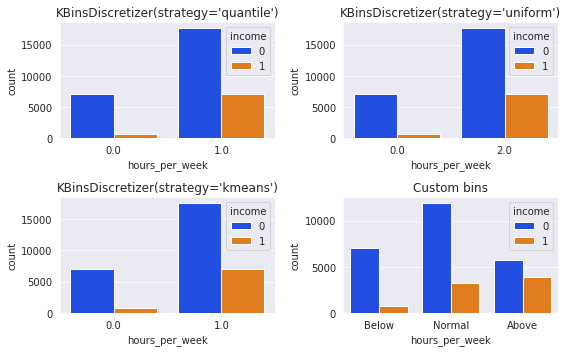

In [149]:
# binning may also be applied
f = plt.figure(figsize=(8,5), tight_layout=True)

kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
data_trans = kbins.fit_transform(trc[['hours_per_week']])
trc['hours_per_week'] = data_trans
ax1 = f.add_subplot(221)
ax1.title.set_text("KBinsDiscretizer(strategy='quantile')")
sns.countplot(x='hours_per_week', hue='income', data=trc)

kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
data_trans = kbins.fit_transform(trc[['hours_per_week']])
trc['hours_per_week'] = data_trans
ax2 = f.add_subplot(222)
ax2.title.set_text("KBinsDiscretizer(strategy='uniform')")
sns.countplot(x='hours_per_week', hue='income', data=trc)

kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
data_trans = kbins.fit_transform(trc[['hours_per_week']])
trc['hours_per_week'] = data_trans
ax3 = f.add_subplot(223)
ax3.title.set_text("KBinsDiscretizer(strategy='kmeans')")
sns.countplot(x='hours_per_week', hue='income', data=trc)

# group by capital differencies
a = pd.cut(train['hours_per_week'], bins=[0, 39, 40, 100], labels=['Below', 'Normal', 'Above'])
ax4 = f.add_subplot(224)
ax4.title.set_text("Custom bins")
res = sns.countplot(x=a, hue='income', data=trc)

save_fig('hours_per_week_kbins')
plt.show()

### marital_status

Saving figure marital_status_dist


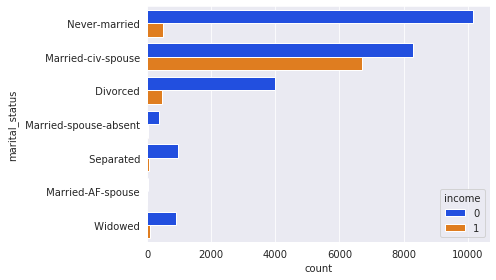

In [110]:
plt.subplots(figsize=(7, 4))
sns.countplot(y='marital_status', hue='income', data=train)
save_fig('marital_status_dist')

In [162]:
train['marital_status'].value_counts()

Married-civ-spouse       14970
Never-married            10667
Divorced                  4441
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital_status, dtype: int64

### education & education number

Saving figure education_dist


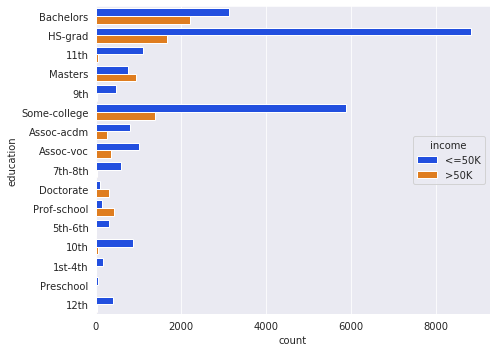

In [84]:
# check if there is any relation between them
plt.subplots(figsize=(7, 5))
sns.countplot(y='education', hue='income', data=train)
save_fig('education_dist')

Saving figure education_num_dist


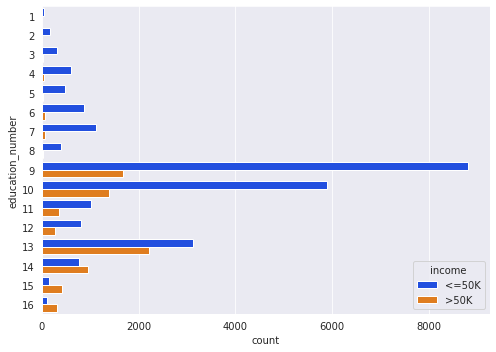

In [85]:
# check if there is any relation between them
plt.subplots(figsize=(7, 5))
sns.countplot(y='education_number', hue='income', data=train)
save_fig('education_num_dist')

In [84]:
# choose unique education classes
ed_classes = train['education'].unique()
ed_classes

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [152]:
train['education_number'].unique()

array([13,  9,  7, 14,  5, 10, 12, 11,  4, 16, 15,  3,  6,  2,  1,  8])

In [92]:
# check whether education class is equal to educational number for all values in dataset
ed_dict = {}
for ed_cl in ed_classes:
    ed_dict[str(ed_cl)] = int(train[(train['education'] == ed_cl)]['education_number'].unique())
    print('"{}": {}'.format(ed_cl, train[(train['education'] == ed_cl)]['education_number'].unique()))

"Bachelors": [13]
"HS-grad": [9]
"11th": [7]
"Masters": [14]
"9th": [5]
"Some-college": [10]
"Assoc-acdm": [12]
"Assoc-voc": [11]
"7th-8th": [4]
"Doctorate": [16]
"Prof-school": [15]
"5th-6th": [3]
"10th": [6]
"1st-4th": [2]
"Preschool": [1]
"12th": [8]


It is clear that 'education_number' and 'education' are just the same and there is also an ordinary character of 'education' column data, so after ordinal encoding it will be just the same as 'education_number'. In order not to do extra encoding step - just drop 'education' column and left as it is without further transformations.

### marital_status & relationship

Saving figure marital_status_dist


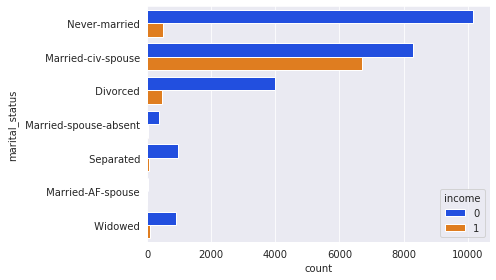

In [108]:
plt.subplots(figsize=(7, 4))
sns.countplot(y='marital_status', hue='income', data=train)
save_fig('marital_status_dist')

Saving figure relationship_dist


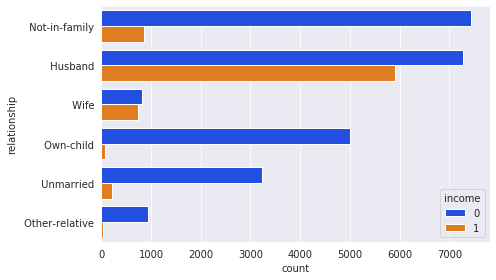

In [107]:
plt.subplots(figsize=(7, 4))
sns.countplot(y='relationship', hue='income', data=train)
save_fig('relationship_dist')

There is no missing values, so we keep them both

### race

Saving figure race_dist


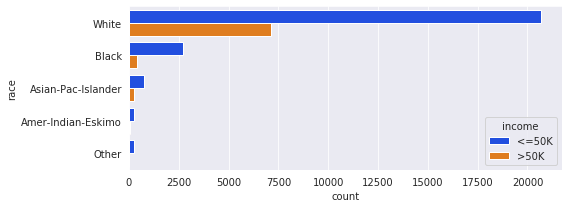

In [40]:
plt.subplots(figsize=(8, 3))
sns.countplot(y='race', hue='income', data=train)
save_fig('race_dist')

There is also no missing values so we'll keep entire row

### sex 

Saving figure sex_dist


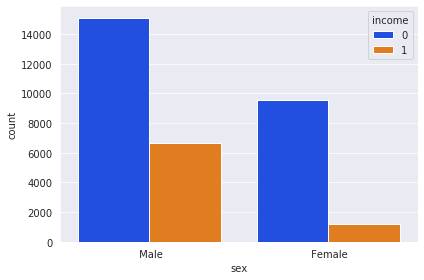

In [105]:
sns.countplot(x='sex', hue='income', data=train)
save_fig('sex_dist')

From the plot above, it is clear that: 
1. There are more Male participants than Female participants
2. When we compare the two genders and the corresponding income distribution, more percentage of Males have an Income of more than \\$50K than Females.

## Pipeline
#### Create Pipeline for chaining all data preprocessing steps + model building & evaluating that particular transformations

In [5]:
def split_enc_dataset(data):
    data.drop_duplicates(inplace=True)
    y = LabelEncoder().fit_transform(data.iloc[:, -1])
    X = data.iloc[:, 0:-1]
    return X, y

train = get_data(path=train_set_path, skiprows=[])
test = get_data(path=test_set_path, skiprows=[0])

X_train, y_train = split_enc_dataset(train)
X_test, y_test = split_enc_dataset(test)

In [6]:
def cleaning(data):
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    striped = (
        data
        .select_dtypes(exclude=['int', 'float'])
        .applymap(lambda x: str(x).strip(" "))
        .replace('nan', np.nan))
    data.update(striped)
    filt = (data['work_class'] == 'Never-worked')
    data.loc[filt] = data.loc[filt].fillna('Unemployed')
    data.reset_index(drop=True, inplace=True)
    return data

In [7]:
def add_new_feature(data):
    x2 = np.array(data.iloc[:, data.columns.get_loc('capital_gain')])
    x1 = np.array(data.iloc[:, data.columns.get_loc('capital_loss')])
    new = np.subtract(x2, x1)
    data['capital_diff'] = new.reshape(-1, 1)
    return data

In [8]:
def drop_features(data, feat_to_drop):
    if feat_to_drop:
        data = data.drop(feat_to_drop, axis=1)
    return data

In [9]:
add_drop_features = Pipeline([
    ('attr_adder', FunctionTransformer(add_new_feature, validate=False)),
    ('attr_dropper', FunctionTransformer(func=drop_features, 
                                         kw_args={'feat_to_drop': ['education']}, 
                                         validate=False)),
])

num_pipeline = Pipeline([
    ('imputer', IterativeImputer()),
    ('q_trans', QuantileTransformer(n_quantiles=100, 
                                    random_state=111, 
                                    output_distribution='normal')
    ),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

transformation = ColumnTransformer([
    ("passthrough_numeric", "passthrough", ["education_number"]),
    ("num_pipeline", num_pipeline, selector(dtype_include=np.number)),
    ("cat_pipeline", cat_pipeline, selector(dtype_exclude=np.number))
])

prepare = Pipeline([
    ('cleaning', FunctionTransformer(cleaning, validate=False)),
    ('add_drop', add_drop_features),
    ('transformation', transformation),
])

full_pipeline_with_predictor = Pipeline([
    ('prepare', prepare),
    ("r_forest", RandomForestClassifier(random_state=42))
])

In [10]:
def evaluate_pipe(pipe, t_score=False):
    pipe.fit(X_train, y_train)
    if t_score:
        y_pred = pipe.predict(X_test)
        scores = accuracy_score(y_test, y_pred)
    else:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)
        scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', 
                                 cv=cv, n_jobs=-1, error_score='raise')        
    return scores

def plot_results(results, mean_scores, names, figsize=(10, 3)):
    ticks = []
    for n, name in enumerate(names):
        ticks.append(name + '\n' + str(round(mean_scores[n], 4)))
    plt.figure(figsize=figsize)
    plt.boxplot(results, labels=ticks)
    plt.show()

def result(pipes, figsize=(10, 2.5), test_score=False, box_plot=True, output=True):
    # evaluate the pipelines and store results
    results, names, mean_scores = list(), list(), list()
    if len(pipes) == 1:
        for name, pipe in pipes.items():
            if test_score:
                score = evaluate_pipe(pipe, t_score=True)
                names.append(name)
                mean_scores.append(score)
                print('Test Accuracy: %.4f' % score)
                box_plot = False
            else:
                scores = evaluate_pipe(pipe)
                mean_scores.append(np.mean(scores))
                names.append(name)
                print('Accuracy: %.4f (%.3f)' % (np.mean(scores), np.std(scores)))
        
    else:
        for name, pipe in pipes.items():
            if test_score:
                scores = evaluate_pipe(pipe, t_score=True)
                mean_scores.append(scores)
                names.append(name)
                box_plot = False
                if output:
                    print('>%s (test accuracy): %.4f' % (name, scores))
            else:
                scores = evaluate_pipe(pipe)
                results.append(scores)
                names.append(name)
                mean_scores.append(np.mean(scores))
                if output:
                    print('>%s %.4f (%.3f)' % (name, np.mean(scores), np.std(scores)))
        if box_plot:
            plot_results(results, mean_scores, names, figsize)
    return mean_scores, names

def select_best(mean_scores, names):
    max_v_ind = np.argmax(mean_scores)
    return names[max_v_ind]

def pick_best(pipelines, figsize, output=True, box_plot=True):
    mean_scores, names = result(pipelines, output=output, box_plot=box_plot, figsize=figsize)
    best_strat = select_best(mean_scores, names)
    pipe_best_strat = pipelines[best_strat]
    return pipe_best_strat

def save(pipe, name):
    # save model to file
    joblib.dump(pipe, "{}_pipe.joblib.dat".format(name))
    print("Saved pipeline to: {}_pipe.joblib.dat".format(name))
    
def update_prepr_pipe(num_trans, num_imputer=('imputer', IterativeImputer())):
    add_drop_features = Pipeline([
        ('attr_adder', FunctionTransformer(add_new_feature, validate=False)),
        ('attr_dropper', FunctionTransformer(func=drop_features, 
                                             kw_args={'feat_to_drop': ['education']}, 
                                             validate=False)
        ),
    ])
    
    num_pipeline = Pipeline([
        num_imputer,
        num_trans      
    ])
    
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    transformation = ColumnTransformer([
        ("passthrough_numeric", "passthrough", ["education_number"]),
        ("num_pipeline", num_pipeline, selector(dtype_include=np.number)),
        ("cat_pipeline", cat_pipeline, selector(dtype_exclude=np.number))
    ])
    
    prepare = Pipeline([
        ('cleaning', FunctionTransformer(cleaning, validate=False)),
        ('add_drop', add_drop_features),
        ('transformation', transformation),
    ])
    return prepare

In [27]:
def evaluate_pipe(pipe, t_score=False):
    pipe.fit(X_train, y_train)
    if t_score:
        y_pred = pipe.predict(X_test)
        scores = accuracy_score(y_test, y_pred)
    else:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)
        scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', 
                                 cv=cv, n_jobs=-1, error_score='raise')        
    return scores

def plot_results(results, mean_scores, names, figsize=(10, 3)):
    ticks = []
    for n, name in enumerate(names):
        ticks.append(name + '\n' + str(round(mean_scores[n], 4)))
    plt.figure(figsize=figsize)
    plt.boxplot(results, labels=ticks)
    plt.show()

def result(pipes, figsize=(10, 2.5), test_score=False, box_plot=True, output=True):
    # evaluate the pipelines and store results
    results, names, mean_scores = list(), list(), list()
    if len(pipes) == 1:
        for name, pipe in pipes.items():
            if test_score:
                score = evaluate_pipe(pipe, t_score=True)
                names.append(name)
                mean_scores.append(score)
                print('Test Accuracy: %.4f' % score)
                box_plot = False
            else:
                scores = evaluate_pipe(pipe)
                mean_scores.append(np.mean(scores))
                names.append(name)
                print('Accuracy: %.4f (%.3f)' % (np.mean(scores), np.std(scores)))
        
    else:
        for name, pipe in pipes.items():
            if test_score:
                scores = evaluate_pipe(pipe, t_score=True)
                mean_scores.append(scores)
                names.append(name)
                box_plot = False
                if output:
                    print('>%s (test accuracy): %.4f' % (name, scores))
            else:
                scores = evaluate_pipe(pipe)
                results.append(scores)
                names.append(name)
                mean_scores.append(np.mean(scores))
                if output:
                    print('>%s %.4f (%.3f)' % (name, np.mean(scores), np.std(scores)))
        if box_plot:
            plot_results(results, mean_scores, names, figsize)
    return mean_scores, names

def select_best(mean_scores, names):
    max_v_ind = np.argmax(mean_scores)
    return names[max_v_ind]

def pick_best(pipelines, figsize, output=True, box_plot=True):
    mean_scores, names = result(pipelines, output=output, box_plot=box_plot, figsize=figsize)
    best_strat = select_best(mean_scores, names)
    pipe_best_strat = pipelines[best_strat]
    return pipe_best_strat

def save(pipe, name):
    # save model to file
    joblib.dump(pipe, "{}_pipe.joblib.dat".format(name))
    print("Saved pipeline to: {}_pipe.joblib.dat".format(name))

### Transformation 

In [227]:
# search for the best data preparation techniques
def get_transform():
    transformators = dict()
    # normalize
    p = MinMaxScaler()     
    transformators['norm'] = ('norm', p)
    # standardize
    p = StandardScaler()
    transformators['std'] = ('std', p)
    # quantile
    p = QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=42)
    transformators['quan'] = ('quan', p)
    # discretize
    p = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
    transformators['kbins'] = ('kbins', p)
    # power transformation
    p = PowerTransformer(method='yeo-johnson')
    transformators['power'] = ('power', p)
    # pca
    p = PCA(n_components=5, random_state=42)
    transformators['pca'] = ('pca', p)
    # svd
    p = TruncatedSVD(n_components=5, random_state=42)
    transformators['svd'] = ('svd', p)

def return_trans(name):
    t = get_transform()
    return t[name]

def get_pipelines(
        models, transformators=return_trans('quan'), single_pipe=False, 
        single_mod=False, single_trans=False):
    if single_pipe:
        name = list(transformators.keys())[0]
        prepare = update_prepr_pipe(num_trans=transformators[name])
        pipelines = Pipeline(steps=[('p', prepare), ('m', models)])
    else:
        pipelines = dict()
        if single_mod:
            for trans in transformators.items():
                # update transformation technique for numerical data
                prepare = update_prepr_pipe(num_trans=trans[1])
                # define full pipeline
                pipelines[trans[0]] = Pipeline(steps=[('p', prepare), ('m', models)])
        if single_trans:
            for mod in models.items():
                # update transformation technique for numerical data
                prepare = update_prepr_pipe(num_trans=transformators)
                # define full pipeline
                pipelines[mod[0]] = Pipeline(steps=[('p', prepare), mod[1]])
    return pipelines

In [230]:
# searching for best 'degree' value of PolynomialFeature transformation class 
def get_pipe_poly(model):
    pipelines = dict()
    for d in range(1, 4):
        prepare = update_prepr_pipe(num_trans=('poly', PolynomialFeatures(degree=d)))
        pipelines[str(d)] = Pipeline(steps=[('p', prepare), ('m', model)])
    return pipelines

>1 0.7429 (0.006)
>2 0.8070 (0.006)
>3 0.7796 (0.004)
>4 0.7796 (0.004)


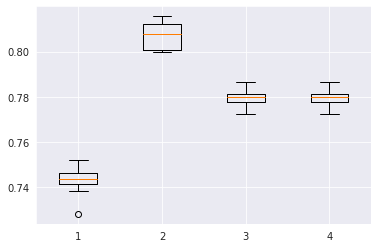

In [231]:
pipelines = get_pipe_poly(model)
_, _ = result(pipelines) 

>ascending 0.7658 (0.005)
>descending 0.7658 (0.005)
>roman 0.7658 (0.005)
>arabic 0.7658 (0.005)
>random 0.7658 (0.005)


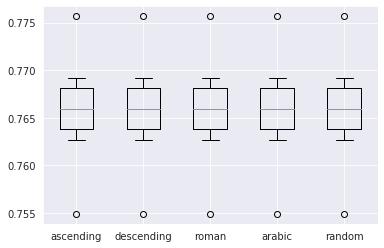

In [232]:
# searching for best strategy of missing values imputation
def get_pipe_imp(model):
    pipelines = dict()
    strategies = ['ascending', 'descending', 'roman', 'arabic', 'random']
    for s in strategies:
        num_imputer = ('i', IterativeImputer(imputation_order=s))
        num_trans = ('q_trans', QuantileTransformer(n_quantiles=100, random_state=111, 
                                                    output_distribution='normal')
                    )
        prepare = update_prepr_pipe(num_trans=num_trans, num_imputer=num_imputer)
        pipelines[str(s)] = Pipeline(steps=[('p', prepare), ('m', model)])
    return pipelines

# get the models to evaluate
pipelines = get_pipe_imp(model)
_, _ = result(pipelines)

>1 0.7658 (0.005)
>2 0.7658 (0.005)
>3 0.7658 (0.005)
>4 0.7658 (0.005)
>5 0.7658 (0.005)
>6 0.7658 (0.005)
>7 0.7658 (0.005)
>8 0.7658 (0.005)
>9 0.7658 (0.005)
>10 0.7658 (0.005)
>11 0.7658 (0.005)
>12 0.7658 (0.005)
>13 0.7658 (0.005)
>14 0.7658 (0.005)
>15 0.7658 (0.005)


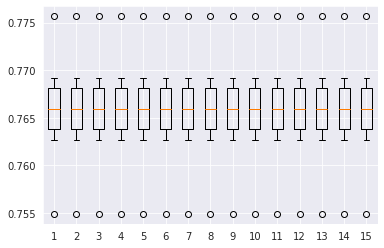

In [233]:
# the 'ascending' imputation order is set by default in IterativeImputer
# serching for the best 'max_iter' value 
def get_pipe_imp(model):
    pipelines = dict()
    iterations = [str(i) for i in range(1, 16)]
    for i in iterations:
        num_imputer = ('i', IterativeImputer(max_iter=int(i)))
        num_trans = ('q_trans', QuantileTransformer(n_quantiles=100, random_state=111, 
                                                    output_distribution='normal')
                    )
        prepare = update_prepr_pipe(num_trans=num_trans, num_imputer=num_imputer)
        pipelines[str(i)] = Pipeline(steps=[('p', prepare), ('m', model)])
    return pipelines

# get the models to evaluate
pipelines = get_pipe_imp(model)
_, _ = result(pipelines)

>1 0.8315 (0.005)
>2 0.8583 (0.004)
>3 0.8581 (0.004)
>4 0.8601 (0.003)
>5 0.8613 (0.004)
>6 0.8614 (0.004)
>7 0.8519 (0.018)


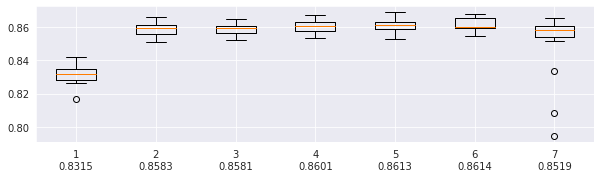

In [49]:
# search for the best number of n_components
def get_pipes_pca(model):
    pipelines = dict()
    for i in range(1, 8):
        num_trans = ('pca', PCA(n_components=i))
        prepare = update_prepr_pipe(num_trans=num_trans)
        pipelines[str(i)] = Pipeline(steps=[('p', prepare), ('m', model)])
    return pipelines

pipes = get_pipes_pca(XGBClassifier())
_, _ = result(pipes)

## Training ML algorithms

This part includes:
1. choosing proper algorithms to deal with imbalance data;
2. visualizations of results (PR curves & ROC curves);
3. hyperparameters tuning;
4. visualizations of results (PR curves & ROC curves);
5. calibration;
6. visualizations of results (PR curves & ROC curves);

In [21]:
# define model for baseline evaluation
dummy = DummyClassifier(strategy='most_frequent')
# cross_val
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(dummy, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Baseline accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Baseline accuracy: 0.759 (0.000)


In [50]:
dummy = DummyClassifier(strategy='most_frequent')
score, _ = evaluate_pipe(dummy, t_score=True)
score

0.763701155074957

In [164]:
# define models to test
def get_models():
    models = dict()
    models['GNB'] = ('GNB', GaussianNB())
    models['BNB'] = ('BNB', BernoulliNB())
    models['CART'] = ('CART', DecisionTreeClassifier(random_state=42))
    models['LR'] = ('LR', LogisticRegression(solver='lbfgs', random_state=42))
    models['BAG'] = ('BAG', BaggingClassifier(n_estimators=100, random_state=42))
    models['KN'] = ('KN', KNeighborsClassifier())
    models['RF'] = ('RF', RandomForestClassifier(n_estimators=100, random_state=42))
    models['GBM'] = ('GBM', GradientBoostingClassifier(n_estimators=100, random_state=42))
    models['ETC'] = ('ETC', ExtraTreesClassifier(n_estimators=100, random_state=42))
    models['XGB'] = ('XGB', XGBClassifier(n_estimators=100, random_state=42))
    models['SVC'] = ('SVC', SVC(random_state=42))
    return models

In [10]:
def plot_pr_roc_curve(pipelines):
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    # plot the no skill precision-recall curve
    ax1.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Baseline')
    for pipe in pipelines.items():
        pipe[1].fit(X_train, y_train)
        # predict probabilities
        yhat = pipe[1].predict_proba(X_test)
        # retrieve just the probabilities for the positive class
        pos_probs = yhat[:, 1]
        # calculate model precision-recall curve
        precision, recall, _ = precision_recall_curve(y_test, pos_probs)
        # calculate the precision-recall auc
        auc_score = auc(recall, precision)
        # plot the model precision-recall curve
        label = pipe[0] + ' PR AUC:' + ' {0:.4f}'.format(auc_score)
        ax1.plot(recall, precision, label=label, linewidth=3)
    ax1.set_title('Precision-Recall Curve')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.legend(loc='lower left')
    #ax1.show()
    # plot_roc_curve
    ax2.plot([0,1], [0,1], 'r--')
    for pipe in pipelines.items():
        pipe[1].fit(X_train, y_train)
        probs = pipe[1].predict_proba(X_test)
        # Reading probability of second class
        probs = probs[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        label = pipe[0] + ' AUC:' + ' {0:.4f}'.format(roc_auc)
        ax2.plot(fpr, tpr, label=label, linewidth=3)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic')
    ax2.legend(loc='lower right')    

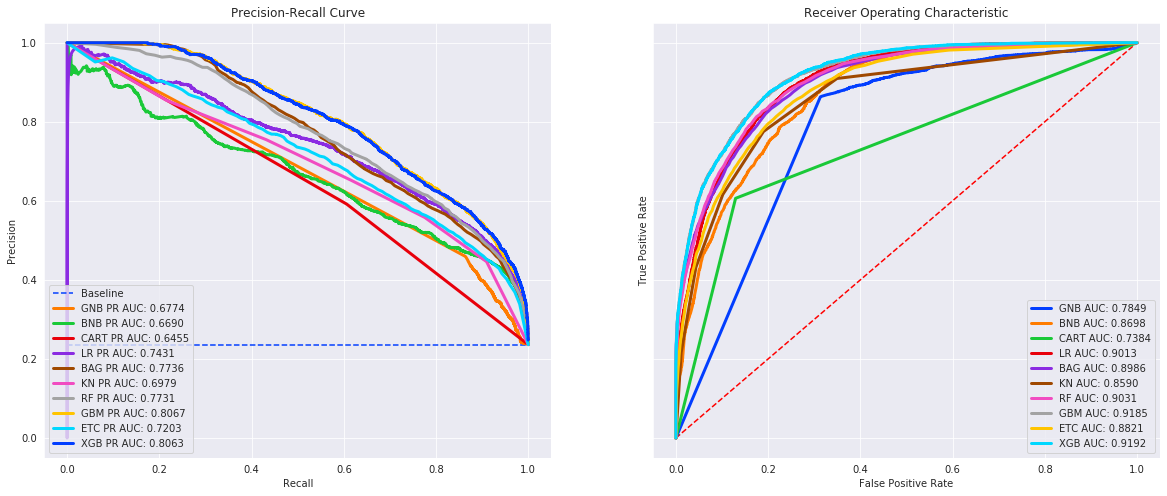

In [82]:
models = get_models()
pipelines = get_pipelines(models=models, single_pipe=False, single_mod=False, single_trans=True)
plot_pr_roc_curve(pipelines)

>EE 0.819 (0.005)
>BBAG 0.834 (0.004)
>BRF 0.815 (0.006)
>GNB 0.534 (0.012)
>BNB 0.766 (0.007)
>CART 0.813 (0.006)
>LR 0.849 (0.006)
>BAG 0.855 (0.006)
>KN 0.831 (0.005)
>RF 0.856 (0.005)
>GBM 0.864 (0.004)
>ETC 0.842 (0.005)
>XGB 0.863 (0.005)


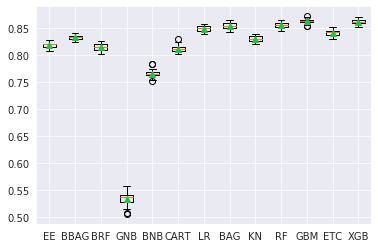

([0.8185245233734728,
  0.8335536364932047,
  0.8149901186511334,
  0.5337007529903369,
  0.7658564899007698,
  0.8125212362874596,
  0.8491666463554074,
  0.8545961513911199,
  0.830562209985922,
  0.8561226983958136,
  0.8641238198292432,
  0.8416060241746182,
  0.8626486839280251],
 ['EE',
  'BBAG',
  'BRF',
  'GNB',
  'BNB',
  'CART',
  'LR',
  'BAG',
  'KN',
  'RF',
  'GBM',
  'ETC',
  'XGB'])

In [220]:
# get the models to evaluate (all)
models = get_models()
pipelines = get_pipelines(models=models, single_pipe=False, single_mod=False, single_trans=True)
scores, names = result(pipelines)

In [ ]:
# test score
models = get_models()
pipelines = get_pipelines(models=models, single_pipe=False, single_mod=False, single_trans=True)
_, _ = result(pipelines, test_score=True)

In [52]:
# cv score
models = get_models()
pipelines = get_pipelines(models=models, single_pipe=False, single_mod=False, single_trans=True)
_, _ = result(pipelines)

>BBAG 0.8329 (0.002)
>GNB 0.5232 (0.017)
>BNB 0.7658 (0.005)
>CART 0.8150 (0.004)
>LR 0.8491 (0.004)
>BAG 0.8539 (0.004)
>KN 0.8316 (0.003)
>RF 0.8578 (0.003)
>GBM 0.8631 (0.002)
>ETC 0.8415 (0.002)
>XGB 0.8625 (0.003)
>SVC 0.8482 (0.003)


### Hyperparameters tuning

In [15]:
def best_prepr(model):
    pipelines = {}
    models = get_models()
    transformators = get_transform()
    for name, trans in transformators.items():
        pr = update_prepr_pipe(num_trans=trans)
        pipelines[str(name)] = Pipeline(steps=[('pr', pr), ('m', model)])
    mean_scores, names = result(pipelines, output=False, figsize=(10, 2.5))
    best_strat = select_best(mean_scores, names)
    pipe_best_strat = pipelines[best_strat]
    return pipe_best_strat

In [16]:
def search(grid, mod_name, scoring='accuracy'):
    pipe = best_prepr(mod_name)
    # define grid search
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = RandomizedSearchCV(pipe, grid, n_jobs=-1, cv=cv, scoring=scoring, error_score=0)
    grid_result = grid_search.fit(X_train, y_train)
    return grid_result

def grid_search_result(grid_result):
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

# preprocessing strategies
def get_model_prep_strat(strategies):
    trans = {}
    for strategy in strategies:
        trans[str(strategy)] = return_trans(strategy)
    return trans

# load models
def load_return_pipe(names):
    pipelines = dict()
    if len(names) == 1:
        pipe = "{}_pipe.joblib.dat".format(names[0])
        pipelines[names[0]] = joblib.load(pipe)
    elif len(names) > 1:
        for name in names:
            pipe = "{}_pipe.joblib.dat".format(name)
            pipelines[name] = joblib.load(pipe)
    else:
        print('List must contain at least one element.')
    return pipelines

#### SVC

In [56]:
svc_p = best_prepr('SVC')
save(svc_p, 'SVC')

>quan 0.8482 (0.003)
>std 0.8512 (0.003)
>norm 0.8363 (0.004)
>power 0.8503 (0.003)
>pca 0.7930 (0.003)
>svd 0.7928 (0.003)
Saved pipeline to: SVC_pipe.joblib.dat


#### BernoulliNB

In [341]:
bnb_p = best_prepr('BNB')
save(bnb_p, 'BNB')

>quan 0.7661 (0.004)
>std 0.7621 (0.005)
>norm 0.7377 (0.006)
>power 0.7650 (0.005)
>pca 0.7455 (0.005)
>svd 0.7418 (0.005)
Saved pipeline to: BNB_pipe.joblib.dat


#### GaussianNB

In [62]:
gnb_p = best_prepr('GNB')
save(gnb_p, 'GNB')

>quan 0.5232 (0.017)
>std 0.5293 (0.019)
>norm 0.5293 (0.019)
>power 0.5235 (0.018)
>pca 0.7879 (0.005)
>svd 0.7877 (0.005)
Saved pipeline to: GNB_pipe.joblib.dat


#### LogisticRegression

>quan 0.849 (0.006)
>std 0.850 (0.006)
>norm 0.851 (0.006)
>power 0.849 (0.006)
>pca 0.778 (0.012)
>svd 0.792 (0.005)


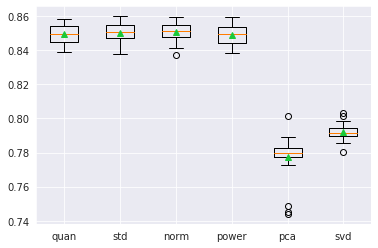

Best: 0.850960 using {'LR__solver': 'lbfgs', 'LR__penalty': 'l2', 'LR__max_iter': 200, 'LR__class_weight': 3, 'LR__C': 1.0}
0.850693 (0.005310) with: {'LR__solver': 'lbfgs', 'LR__penalty': 'l2', 'LR__max_iter': 200, 'LR__class_weight': 3, 'LR__C': 10}
0.808341 (0.005787) with: {'LR__solver': 'lbfgs', 'LR__penalty': 'l2', 'LR__max_iter': 100, 'LR__class_weight': 'balanced', 'LR__C': 10}
0.836166 (0.005588) with: {'LR__solver': 'lbfgs', 'LR__penalty': 'l2', 'LR__max_iter': 200, 'LR__class_weight': 3, 'LR__C': 0.01}
0.849341 (0.004966) with: {'LR__solver': 'lbfgs', 'LR__penalty': 'l2', 'LR__max_iter': 50, 'LR__class_weight': 2, 'LR__C': 100}
0.836166 (0.005588) with: {'LR__solver': 'lbfgs', 'LR__penalty': 'l2', 'LR__max_iter': 300, 'LR__class_weight': 1, 'LR__C': 0.01}
0.808505 (0.005597) with: {'LR__solver': 'lbfgs', 'LR__penalty': 'l2', 'LR__max_iter': 200, 'LR__class_weight': 'balanced', 'LR__C': 10}
0.850960 (0.005298) with: {'LR__solver': 'lbfgs', 'LR__penalty': 'l2', 'LR__max_iter':

In [37]:
# define search grid
grid = {
    'LR__C': [100, 10, 1.0, 0.1, 0.01],
    'LR__solver': ['lbfgs'],
    'LR__class_weight': ['balanced', None, 1, 2, 3],
    "LR__penalty": ['l2'],
    "LR__max_iter": [50, 100, 200, 300]
}

# randomized grid search with best preprocessing technique of a given model 
grid_result = search(grid, 'LR')
grid_search_result(grid_result)
save(grid_result.best_estimator_, 'LR')

#### KNeighborsClassifier

>quan 0.831 (0.005)
>std 0.839 (0.005)
>norm 0.828 (0.006)
>power 0.838 (0.005)
>pca 0.773 (0.004)
>svd 0.773 (0.004)


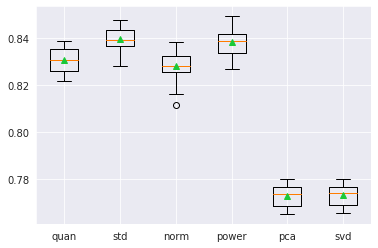

Best: 0.850529 using {'KN__weights': 'uniform', 'KN__n_neighbors': 29, 'KN__metric': 'euclidean'}
0.848665 (0.005756) with: {'KN__weights': 'distance', 'KN__n_neighbors': 96, 'KN__metric': 'euclidean'}
0.000000 (0.000000) with: {'KN__weights': 'uniform', 'KN__n_neighbors': 46, 'KN__metric': 'manhatan'}
0.848624 (0.005353) with: {'KN__weights': 'distance', 'KN__n_neighbors': 81, 'KN__metric': 'euclidean'}
0.000000 (0.000000) with: {'KN__weights': 'uniform', 'KN__n_neighbors': 23, 'KN__metric': 'manhatan'}
0.000000 (0.000000) with: {'KN__weights': 'distance', 'KN__n_neighbors': 78, 'KN__metric': 'manhatan'}
0.850529 (0.005496) with: {'KN__weights': 'uniform', 'KN__n_neighbors': 29, 'KN__metric': 'euclidean'}
0.000000 (0.000000) with: {'KN__weights': 'distance', 'KN__n_neighbors': 9, 'KN__metric': 'manhatan'}
0.000000 (0.000000) with: {'KN__weights': 'distance', 'KN__n_neighbors': 69, 'KN__metric': 'manhatan'}
0.000000 (0.000000) with: {'KN__weights': 'distance', 'KN__n_neighbors': 60, 'K

In [211]:
grid = {
    'KN__n_neighbors': range(2, 100),
    'KN__weights': ['uniform', 'distance'],
    'KN__metric': ['euclidean']
}

grid_result = search(grid, 'KN')
grid_search_result(grid_result)
save(grid_result.best_estimator_, 'KN')

#### Bagged Decision Trees (Bagging)

>quan 0.855 (0.006)
>std 0.855 (0.006)
>norm 0.854 (0.005)
>power 0.855 (0.006)
>pca 0.854 (0.004)
>svd 0.849 (0.004)


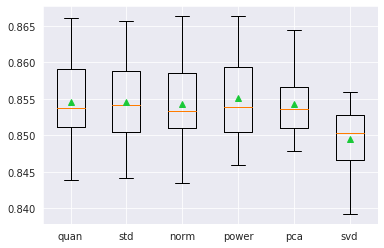

Best: 0.863407 using {'BAG__n_estimators': 1000, 'BAG__max_samples': 0.1}
0.853838 (0.005387) with: {'BAG__n_estimators': 100, 'BAG__max_samples': 1.0}
0.855846 (0.005066) with: {'BAG__n_estimators': 700, 'BAG__max_samples': 0.9}
0.854760 (0.005390) with: {'BAG__n_estimators': 1000, 'BAG__max_samples': 1.0}
0.863407 (0.003971) with: {'BAG__n_estimators': 1000, 'BAG__max_samples': 0.1}
0.860252 (0.004611) with: {'BAG__n_estimators': 500, 'BAG__max_samples': 0.5}
0.854842 (0.005072) with: {'BAG__n_estimators': 200, 'BAG__max_samples': 0.9}
0.861676 (0.003988) with: {'BAG__n_estimators': 100, 'BAG__max_samples': 0.3}
0.863274 (0.004762) with: {'BAG__n_estimators': 700, 'BAG__max_samples': 0.3}
0.860385 (0.004216) with: {'BAG__n_estimators': 1000, 'BAG__max_samples': 0.5}
0.859832 (0.004268) with: {'BAG__n_estimators': 200, 'BAG__max_samples': 0.5}
Saved pipeline to: BAG_pipe.joblib.dat


In [68]:
grid = {
    'BAG__n_estimators': [100, 200, 400, 500, 700, 1000],
    'BAG__max_samples': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

grid_result = search(grid, 'BAG')
grid_search_result(grid_result)
save(grid_result.best_estimator_, 'BAG')

In [ ]:
#### Balanced Bagged Decision Trees

>quan 0.834 (0.004)
>std 0.834 (0.004)
>norm 0.834 (0.005)
>power 0.833 (0.005)
>pca 0.832 (0.005)
>svd 0.828 (0.004)


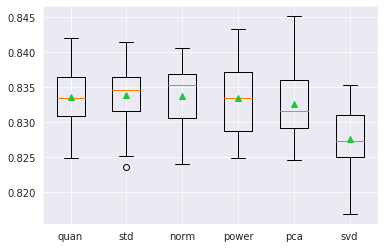

Best: 0.833451 using {'BBAG__n_estimators': 1000, 'BBAG__max_samples': 0.9}
0.831443 (0.004484) with: {'BBAG__n_estimators': 100, 'BBAG__max_samples': 0.7}
0.814468 (0.007016) with: {'BBAG__n_estimators': 400, 'BBAG__max_samples': 0.1}
0.828493 (0.005849) with: {'BBAG__n_estimators': 400, 'BBAG__max_samples': 0.5}
0.822377 (0.005885) with: {'BBAG__n_estimators': 100, 'BBAG__max_samples': 0.3}
0.831915 (0.006257) with: {'BBAG__n_estimators': 10, 'BBAG__max_samples': 1.0}
0.832662 (0.006290) with: {'BBAG__n_estimators': 100, 'BBAG__max_samples': 0.9}
0.822838 (0.005913) with: {'BBAG__n_estimators': 500, 'BBAG__max_samples': 0.3}
0.831351 (0.005367) with: {'BBAG__n_estimators': 400, 'BBAG__max_samples': 0.7}
0.814550 (0.006550) with: {'BBAG__n_estimators': 1000, 'BBAG__max_samples': 0.1}
0.833451 (0.005536) with: {'BBAG__n_estimators': 1000, 'BBAG__max_samples': 0.9}
Saved pipeline to: BBAG_pipe.joblib.dat


In [81]:
grid = {
    'BBAG__n_estimators': [10, 100, 200, 400, 500, 700, 1000],
    'BBAG__max_samples': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

grid_result = search(grid, 'BBAG')
grid_search_result(grid_result)
save(grid_result.best_estimator_, 'BBAG')

#### RandomForests

>quan 0.856 (0.005)
>std 0.856 (0.005)
>norm 0.856 (0.005)
>power 0.855 (0.005)
>pca 0.857 (0.005)
>svd 0.851 (0.005)


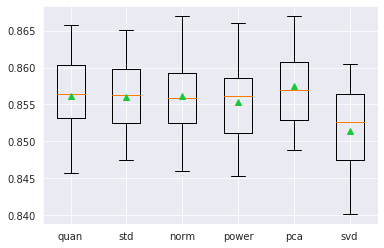

Best: 0.858090 using {'RF__n_estimators': 1000, 'RF__max_features': 'sqrt', 'RF__class_weight': {0: 1, 1: 2}}
0.856287 (0.004154) with: {'RF__n_estimators': 300, 'RF__max_features': 'log2', 'RF__class_weight': {0: 1, 1: 2}}
0.857291 (0.004741) with: {'RF__n_estimators': 100, 'RF__max_features': 'sqrt', 'RF__class_weight': {0: 1, 1: 1}}
0.855672 (0.004950) with: {'RF__n_estimators': 1000, 'RF__max_features': 'log2', 'RF__class_weight': 'balanced'}
0.847436 (0.004884) with: {'RF__n_estimators': 10, 'RF__max_features': 'log2', 'RF__class_weight': {0: 1, 1: 3}}
0.855693 (0.004453) with: {'RF__n_estimators': 200, 'RF__max_features': 'log2', 'RF__class_weight': {0: 1, 1: 2}}
0.858090 (0.004634) with: {'RF__n_estimators': 1000, 'RF__max_features': 'sqrt', 'RF__class_weight': {0: 1, 1: 2}}
0.855703 (0.005210) with: {'RF__n_estimators': 300, 'RF__max_features': 'log2', 'RF__class_weight': {0: 1, 1: 1}}
0.855252 (0.004424) with: {'RF__n_estimators': 500, 'RF__max_features': 'log2', 'RF__class_we

In [69]:
grid = {
    'RF__n_estimators': [10, 100, 200, 300, 500, 1000],
    'RF__max_features': ['sqrt', 'log2'],
    'RF__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, 'balanced']
}

grid_result = search(grid, 'RF')
grid_search_result(grid_result)
save(grid_result.best_estimator_, 'RF')

In [37]:
pipes = get_pipes_pca(model=RandomForestClassifier())
_, _ = result(pipes)

>1 0.7899 (0.004)
>2 0.8275 (0.004)
>3 0.8366 (0.002)
>4 0.8513 (0.003)
>5 0.8584 (0.002)
>6 0.8574 (0.002)
>7 0.8580 (0.003)


#### GradientBoosting

>quan 0.864 (0.004)
>std 0.864 (0.004)
>norm 0.864 (0.004)
>power 0.864 (0.004)
>pca 0.863 (0.005)
>svd 0.856 (0.005)


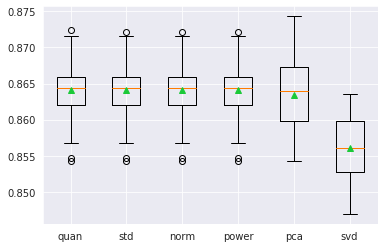

Best: 0.869062 using {'GBM__subsample': 0.5, 'GBM__n_estimators': 500, 'GBM__max_depth': 4, 'GBM__learning_rate': 0.1}
0.759074 (0.000080) with: {'GBM__subsample': 0.5, 'GBM__n_estimators': 100, 'GBM__max_depth': 4, 'GBM__learning_rate': 0.001}
0.759074 (0.000080) with: {'GBM__subsample': 1.0, 'GBM__n_estimators': 300, 'GBM__max_depth': 6, 'GBM__learning_rate': 0.001}
0.858653 (0.004514) with: {'GBM__subsample': 0.7, 'GBM__n_estimators': 300, 'GBM__max_depth': 4, 'GBM__learning_rate': 0.01}
0.843081 (0.004705) with: {'GBM__subsample': 1.0, 'GBM__n_estimators': 100, 'GBM__max_depth': 4, 'GBM__learning_rate': 0.01}
0.859340 (0.004661) with: {'GBM__subsample': 0.5, 'GBM__n_estimators': 900, 'GBM__max_depth': 6, 'GBM__learning_rate': 0.1}
0.861757 (0.004776) with: {'GBM__subsample': 0.5, 'GBM__n_estimators': 300, 'GBM__max_depth': 8, 'GBM__learning_rate': 0.1}
0.869062 (0.004465) with: {'GBM__subsample': 0.5, 'GBM__n_estimators': 500, 'GBM__max_depth': 4, 'GBM__learning_rate': 0.1}
0.81020

In [78]:
grid = {
    'GBM__n_estimators': [100, 300, 500, 900],
    'GBM__learning_rate': [0.001, 0.01, 0.1],
    'GBM__subsample': [0.5, 0.7, 1.0],
    'GBM__max_depth': [4, 6, 8]
}

grid_result = search(grid, 'GBM')
grid_search_result(grid_result)
save(grid_result.best_estimator_, 'GBM')

#### XGBoost

>quan 0.863 (0.005)
>std 0.863 (0.005)
>norm 0.863 (0.005)
>power 0.862 (0.005)
>pca 0.861 (0.004)
>svd 0.855 (0.004)


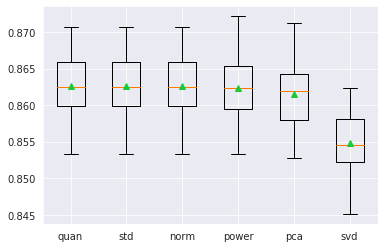

Best: -0.283492 using {'XGB__subsample': 0.6, 'XGB__n_estimators': 150, 'XGB__min_child_weight': 3, 'XGB__max_depth': 9, 'XGB__learning_rate': 0.1, 'XGB__gamma': 0.5, 'XGB__colsample_bytree': 0.8}
-0.402398 (0.003403) with: {'XGB__subsample': 1.0, 'XGB__n_estimators': 100, 'XGB__min_child_weight': 7, 'XGB__max_depth': 9, 'XGB__learning_rate': 0.01, 'XGB__gamma': 0.7, 'XGB__colsample_bytree': 1.0}
-0.297720 (0.005944) with: {'XGB__subsample': 1.0, 'XGB__n_estimators': 100, 'XGB__min_child_weight': 3, 'XGB__max_depth': 3, 'XGB__learning_rate': 0.1, 'XGB__gamma': 0.3, 'XGB__colsample_bytree': 0.8}
-0.283492 (0.007072) with: {'XGB__subsample': 0.6, 'XGB__n_estimators': 150, 'XGB__min_child_weight': 3, 'XGB__max_depth': 9, 'XGB__learning_rate': 0.1, 'XGB__gamma': 0.5, 'XGB__colsample_bytree': 0.8}
-0.314679 (0.005485) with: {'XGB__subsample': 0.8, 'XGB__n_estimators': 100, 'XGB__min_child_weight': 5, 'XGB__max_depth': 3, 'XGB__learning_rate': 0.05, 'XGB__gamma': 0.5, 'XGB__colsample_bytree'

In [64]:
grid = {
    'XGB__n_estimators': [100, 150],
    'XGB__learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'XGB__max_depth': [3, 5, 7, 9, 12, 17],
    'XGB__min_child_weight': [1, 3, 5, 7],
    'XGB__subsample': [0.6, 0.8, 1.0],
    'XGB__colsample_bytree': [0.6, 0.8, 1.0],
    'XGB__gamma': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

grid_result = search(grid, 'XGB', scoring='neg_log_loss')
grid_search_result(grid_result)
save(grid_result.best_estimator_, 'XGB')

#### ExtraTreeClassifier

>quan 0.842 (0.005)
>std 0.843 (0.006)
>norm 0.843 (0.006)
>power 0.840 (0.005)
>pca 0.844 (0.006)
>svd 0.837 (0.006)


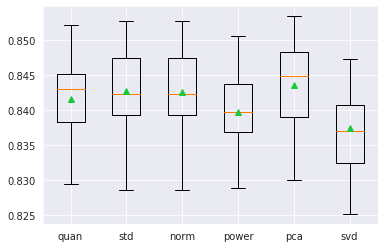

Best: 0.828472 using {'ETC__n_estimators': 500, 'ETC__max_depth': 8, 'ETC__criterion': 'gini'}
0.772065 (0.002504) with: {'ETC__n_estimators': 100, 'ETC__max_depth': 4, 'ETC__criterion': 'entropy'}
0.759074 (0.000080) with: {'ETC__n_estimators': 700, 'ETC__max_depth': 2, 'ETC__criterion': 'gini'}
0.819211 (0.004112) with: {'ETC__n_estimators': 900, 'ETC__max_depth': 6, 'ETC__criterion': 'gini'}
0.818719 (0.003777) with: {'ETC__n_estimators': 900, 'ETC__max_depth': 6, 'ETC__criterion': 'entropy'}
0.759074 (0.000080) with: {'ETC__n_estimators': 100, 'ETC__max_depth': 2, 'ETC__criterion': 'entropy'}
0.818197 (0.003705) with: {'ETC__n_estimators': 500, 'ETC__max_depth': 6, 'ETC__criterion': 'entropy'}
0.774513 (0.002712) with: {'ETC__n_estimators': 100, 'ETC__max_depth': 4, 'ETC__criterion': 'gini'}
0.828114 (0.004754) with: {'ETC__n_estimators': 100, 'ETC__max_depth': 8, 'ETC__criterion': 'entropy'}
0.828472 (0.005049) with: {'ETC__n_estimators': 500, 'ETC__max_depth': 8, 'ETC__criterion'

In [59]:
grid = {
    'ETC__n_estimators': range(100, 1000, 200),
    'ETC__max_depth': [2, 4, 6, 8],
    'ETC__criterion': ['gini', 'entropy']
}

grid_result = search(grid, 'ETC')
grid_search_result(grid_result)
save(grid_result.best_estimator_, 'ETC')

In [39]:
pipes = get_pipes_pca(model=ExtraTreesClassifier())
_, _ = result(pipes)

>1 0.7809 (0.005)
>2 0.8124 (0.003)
>3 0.8206 (0.004)
>4 0.8360 (0.002)
>5 0.8436 (0.004)
>6 0.8427 (0.003)
>7 0.8418 (0.002)


>quan 0.842 (0.005)
>std 0.843 (0.006)
>norm 0.843 (0.006)
>power 0.840 (0.005)
>pca 0.844 (0.006)
>svd 0.837 (0.006)


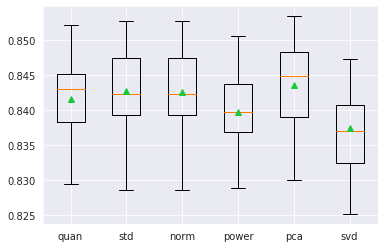

Saved pipeline to: ETC_pipe.joblib.dat


In [60]:
etc_p = best_prepr('ETC')
save(etc_p, 'ETC')

#### DecisionTreeClassifier

>quan 0.813 (0.006)
>std 0.813 (0.006)
>norm 0.813 (0.006)
>power 0.813 (0.006)
>pca 0.812 (0.006)
>svd 0.805 (0.005)


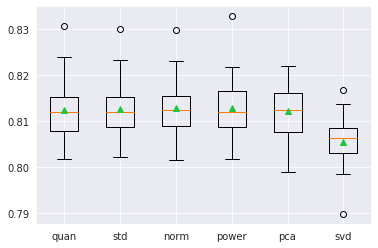

Best: 0.852537 using {'CART__max_depth': 8, 'CART__criterion': 'entropy', 'CART__class_weight': {0: 1, 1: 1}}
0.827335 (0.004966) with: {'CART__max_depth': 2, 'CART__criterion': 'gini', 'CART__class_weight': {0: 1, 1: 1}}
0.757978 (0.007314) with: {'CART__max_depth': 4, 'CART__criterion': 'gini', 'CART__class_weight': {0: 1, 1: 3}}
0.852537 (0.004417) with: {'CART__max_depth': 8, 'CART__criterion': 'entropy', 'CART__class_weight': {0: 1, 1: 1}}
0.797800 (0.005963) with: {'CART__max_depth': 8, 'CART__criterion': 'entropy', 'CART__class_weight': 'balanced'}
0.822243 (0.006123) with: {'CART__max_depth': 8, 'CART__criterion': 'gini', 'CART__class_weight': {0: 1, 1: 2}}
0.804500 (0.007004) with: {'CART__max_depth': 8, 'CART__criterion': 'gini', 'CART__class_weight': 'balanced'}
0.842036 (0.004796) with: {'CART__max_depth': 4, 'CART__criterion': 'entropy', 'CART__class_weight': {0: 1, 1: 1}}
0.787770 (0.010618) with: {'CART__max_depth': 6, 'CART__criterion': 'gini', 'CART__class_weight': {0:

In [56]:
grid = {
    'CART__max_depth': [2, 4, 6, 8],
    'CART__criterion': ['gini', 'entropy'],
    'CART__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, 'balanced']
}

grid_result = search(grid, 'CART')
grid_search_result(grid_result)
save(grid_result.best_estimator_, 'CART')

### Calibration

better calibrated probabilities may or may not lead to better class-based or probability-based predictions. It really depends on the specific metric used to evaluate predictions.

In [18]:
# load models
def load_return_pipelines(names):
    pipelines = dict()
    if len(names) == 1:
        pipe = "{}_pipe.joblib.dat".format(names[0])
        pipelines[names[0]] = joblib.load(pipe)
    elif len(names) > 1:
        for name in names:
            pipe = "{}_pipe.joblib.dat".format(name)
            pipelines[name] = joblib.load(pipe)
    else:
        print('List must contain at least one element.')
    return pipelines

In [18]:
# load tuned models
tuned_mod_names = [
    'BBAG', 'GNB', 'BNB', 'CART', 'LR', 'BAG', 
    'KN', 'RF', 'GBM', 'ETC', 'XGB', 'SVC'
]
tuned_mod_pipes = load_return_pipelines(tuned_mod_names)

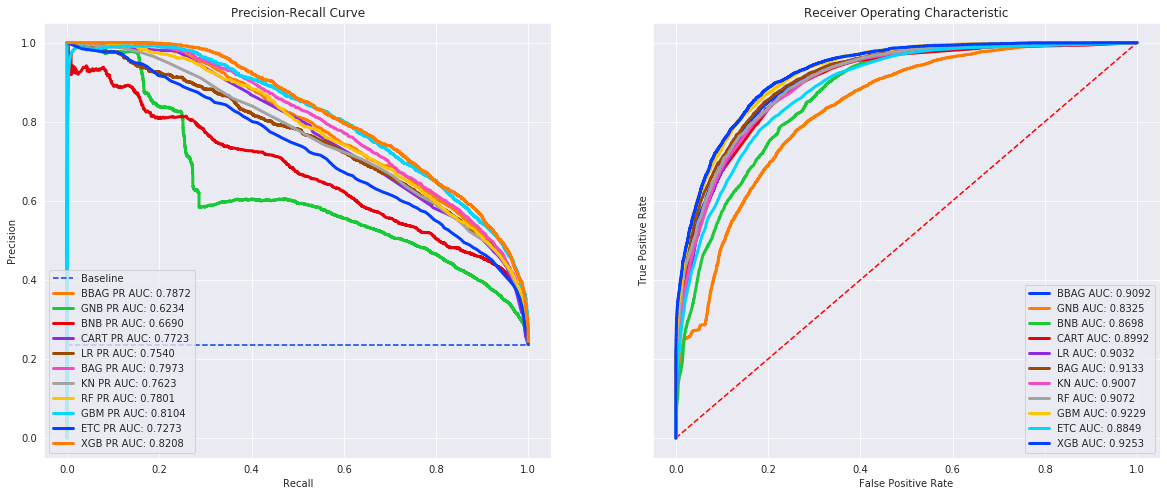

In [38]:
# plot roc-auc & precision-recall curve of tuned models
plot_pr_roc_curve(tuned_mod_pipes)

In [20]:
# predict uncalibrated probabilities
def uncalibrated(X_train, X_test, y_train, pipeline):
    # fit a model
    pipeline.fit(X_train, y_train)
    # predict probabilities
    return pipeline.decision_function(X_test)
 
# update pipeline & predict calibrated probabilities
def calibrated(X_train, X_test, y_train, pipeline):
    # define calibration pipeline
    calibrated = Pipeline([
        ('prepare', pipeline[1][0]),
        ('calibration', CalibratedClassifierCV(pipeline[1][1], method='sigmoid', cv=5))
    ])
    # define and fit calibration model
    calibrated.fit(X_train, y_train)
    # predict probabilities
    return calibrated.predict_proba(X_test)[:, 1]

In [25]:
def plot_calibration_curve(pipelines, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for name, pipe in pipelines.items():
        noncalib_pipeline = pipe
        # Calibrated with isotonic calibration
        calibrated_iso = Pipeline([
            ('prepare', pipe[0]),
            ('model', CalibratedClassifierCV(pipe[1], method='isotonic', cv=5))
        ])
        # Calibrated with sigmoid calibration
        calibrated_sig = Pipeline([
            ('prepare', pipe[0]),
            ('model', CalibratedClassifierCV(pipe[1], method='sigmoid', cv=5))
        ])
        pipelines_to_select = [noncalib_pipeline, calibrated_iso, calibrated_sig]
        mod_br_scores = []
        for pipeline, name in [(noncalib_pipeline, name + ' No Calibration'),
                      (calibrated_iso, name + ' + Isotonic'),
                      (calibrated_sig, name + ' + Sigmoid')]:
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            if hasattr(pipeline, "predict_proba"):
                prob_pos = pipeline.predict_proba(X_test)[:, 1]
            else:  # use decision function
                prob_pos = pipeline.decision_function(X_test)
                prob_pos = \
                    (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
            
            clf_score = brier_score_loss(y_test, prob_pos, pos_label=y_test.max())
            print("%s:" % name)
            print("\tBrier: %1.3f" % (clf_score))
            print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
            print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
            print("\tAccuracy: %1.3f\n" % accuracy_score(y_test, y_pred))
            mod_br_scores.append(-clf_score)

            fraction_of_positives, mean_predicted_value = \
                calibration_curve(y_test, prob_pos, n_bins=10)

            ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                     label="%s (%1.3f)" % (name, clf_score))

            ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                     histtype="step", lw=2)
        best = select_best(mod_br_scores, pipelines_to_select)
        #save(best, str(pipe[0]) + '_calibrated')
        ax1.set_ylabel("Fraction of positives")
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc="lower right")
        ax1.set_title('Calibration plots  (reliability curve)')

        ax2.set_xlabel("Mean predicted value")
        ax2.set_ylabel("Count")
        ax2.legend(loc="upper center", ncol=2)

        plt.tight_layout()

SVC:
	Brier: 0.124
	Precision: 0.759
	Recall: 0.546
	Accuracy: 0.852

SVC:
	Brier: 0.102
	Precision: 0.747
	Recall: 0.566
	Accuracy: 0.852

SVC:
	Brier: 0.105
	Precision: 0.754
	Recall: 0.556
	Accuracy: 0.852

Saved pipeline to: SVC_calibrated_pipe.joblib.dat
BNB:
	Brier: 0.183
	Precision: 0.511
	Recall: 0.794
	Accuracy: 0.772

BNB:
	Brier: 0.118
	Precision: 0.708
	Recall: 0.464
	Accuracy: 0.828

BNB:
	Brier: 0.129
	Precision: 0.589
	Recall: 0.637
	Accuracy: 0.809

Saved pipeline to: BNB_calibrated_pipe.joblib.dat


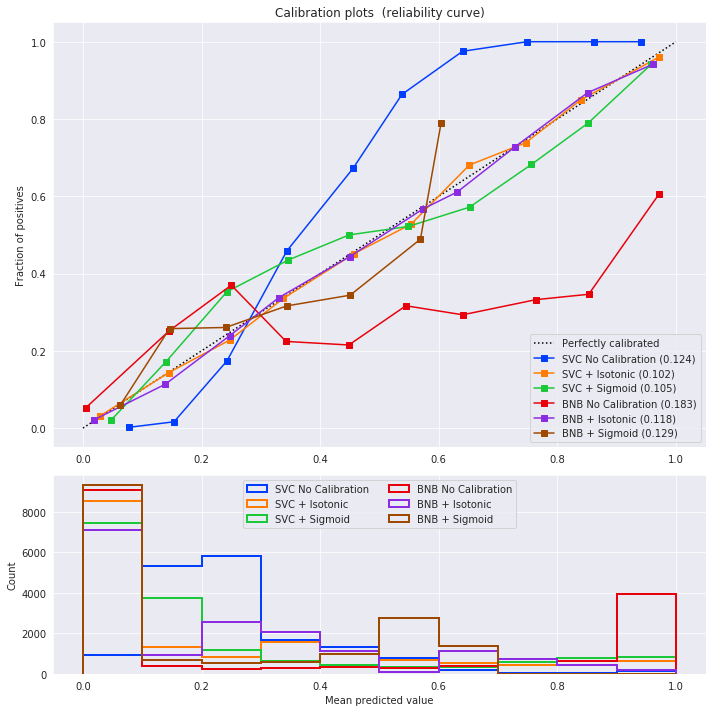

In [34]:
names = ['SVC', 'BNB']
tuned_models = load_return_pipelines(names)

plot_calibration_curve(tuned_models, 1)
plt.show()

GNB:
	Brier: 0.192
	Precision: 0.614
	Recall: 0.286
	Accuracy: 0.789

GNB:
	Brier: 0.128
	Precision: 0.801
	Recall: 0.251
	Accuracy: 0.808

GNB:
	Brier: 0.160
	Precision: 0.621
	Recall: 0.285
	Accuracy: 0.790

Saved pipeline to: GNB_calibrated_pipe.joblib.dat
BNB:
	Brier: 0.183
	Precision: 0.511
	Recall: 0.794
	Accuracy: 0.772

BNB:
	Brier: 0.118
	Precision: 0.708
	Recall: 0.464
	Accuracy: 0.828

BNB:
	Brier: 0.129
	Precision: 0.589
	Recall: 0.637
	Accuracy: 0.809

Saved pipeline to: BNB_calibrated_pipe.joblib.dat


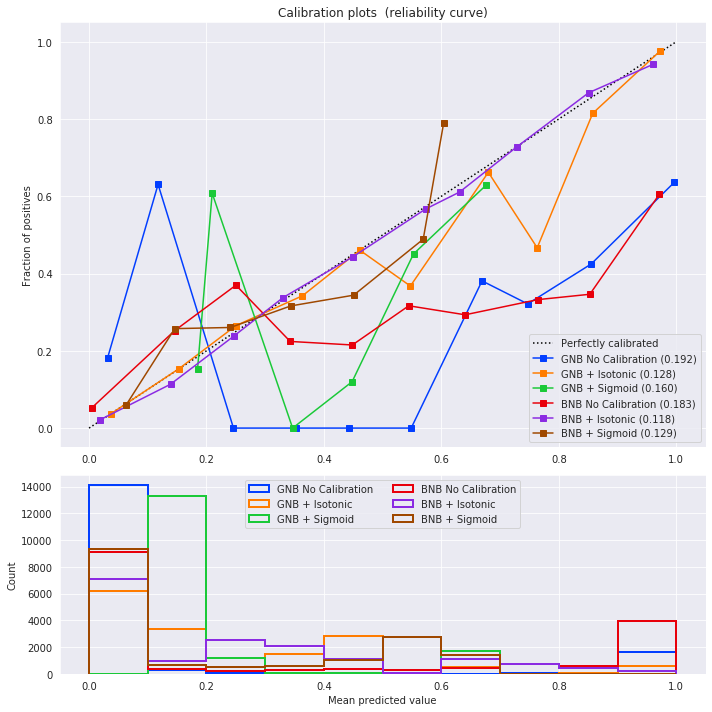

In [70]:
# Plot calibration curve for Gaussian Naive Bayes
names = ['GNB', 'BNB']
tuned_models_1 = load_return_pipelines(names)

plot_calibration_curve(tuned_models_1, 1)
plt.show()

GNB No Calibration:
	Brier: 0.192
	Precision: 0.614
	Recall: 0.286
	Accuracy: 0.789

GNB + Isotonic:
	Brier: 0.128
	Precision: 0.801
	Recall: 0.251
	Accuracy: 0.808

GNB + Sigmoid:
	Brier: 0.160
	Precision: 0.621
	Recall: 0.285
	Accuracy: 0.790

BNB No Calibration:
	Brier: 0.183
	Precision: 0.511
	Recall: 0.794
	Accuracy: 0.772

BNB + Isotonic:
	Brier: 0.118
	Precision: 0.708
	Recall: 0.464
	Accuracy: 0.828

BNB + Sigmoid:
	Brier: 0.129
	Precision: 0.589
	Recall: 0.637
	Accuracy: 0.809



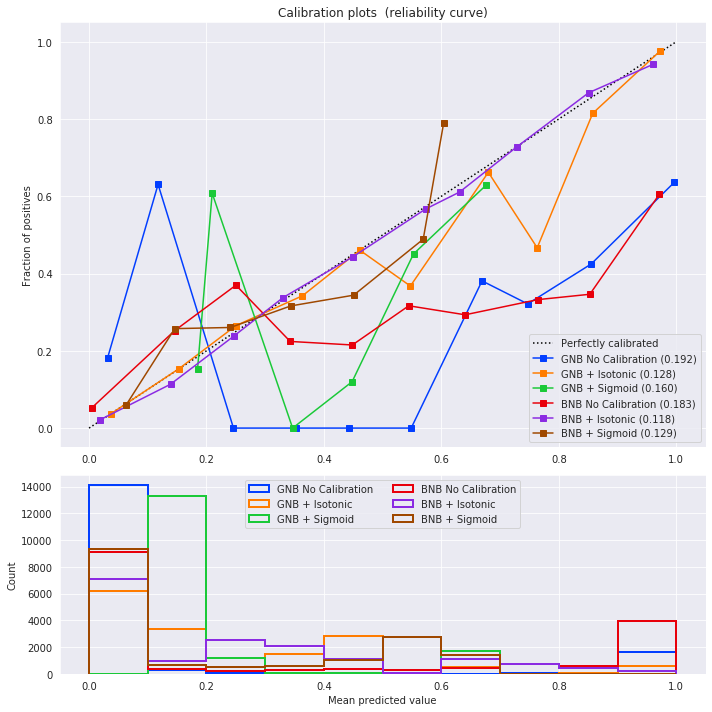

In [28]:
# Plot calibration curve for Gaussian Naive Bayes
names = ['GNB', 'BNB']
tuned_models_1 = load_return_pipelines(names)

plot_calibration_curve(tuned_models_1, 1)
plt.show()

CART:
	Brier: 0.101
	Precision: 0.789
	Recall: 0.528
	Accuracy: 0.855

CART:
	Brier: 0.099
	Precision: 0.788
	Recall: 0.534
	Accuracy: 0.856

CART:
	Brier: 0.100
	Precision: 0.784
	Recall: 0.536
	Accuracy: 0.855

Saved pipeline to: CART_calibrated_pipe.joblib.dat
LR:
	Brier: 0.103
	Precision: 0.724
	Recall: 0.595
	Accuracy: 0.851

LR:
	Brier: 0.103
	Precision: 0.727
	Recall: 0.590
	Accuracy: 0.851

LR:
	Brier: 0.103
	Precision: 0.725
	Recall: 0.597
	Accuracy: 0.851

Saved pipeline to: LR_calibrated_pipe.joblib.dat


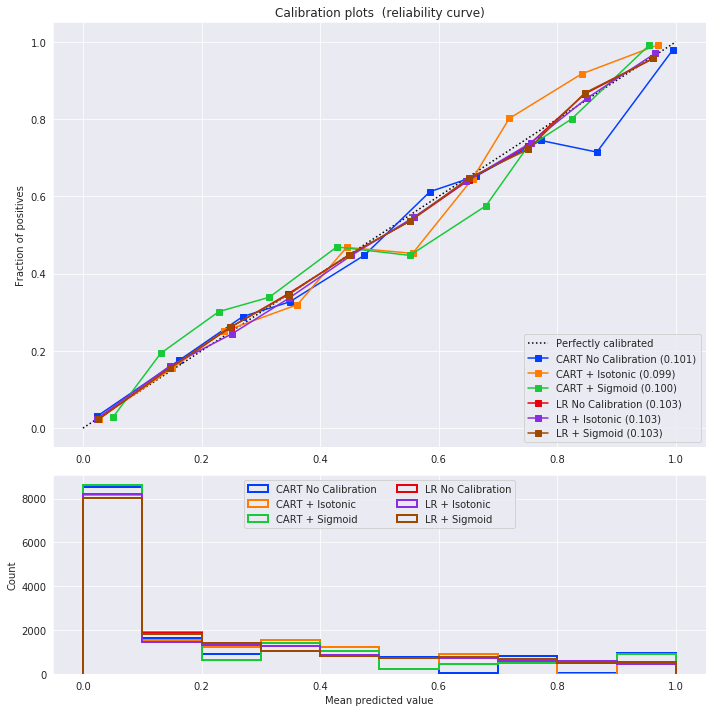

In [31]:
names = ['CART', 'LR']
tuned_models_2 = load_return_pipelines(names)

plot_calibration_curve(tuned_models_2, 2)
plt.show()

BBAG:
	Brier: 0.113
	Precision: 0.608
	Recall: 0.799
	Accuracy: 0.831

BBAG:
	Brier: 0.097
	Precision: 0.754
	Recall: 0.594
	Accuracy: 0.858

BBAG:
	Brier: 0.098
	Precision: 0.726
	Recall: 0.637
	Accuracy: 0.857

Saved pipeline to: BBAG_calibrated_pipe.joblib.dat
KN:
	Brier: 0.103
	Precision: 0.705
	Recall: 0.640
	Accuracy: 0.852

KN:
	Brier: 0.102
	Precision: 0.724
	Recall: 0.596
	Accuracy: 0.851

KN:
	Brier: 0.104
	Precision: 0.724
	Recall: 0.593
	Accuracy: 0.850

Saved pipeline to: KN_calibrated_pipe.joblib.dat


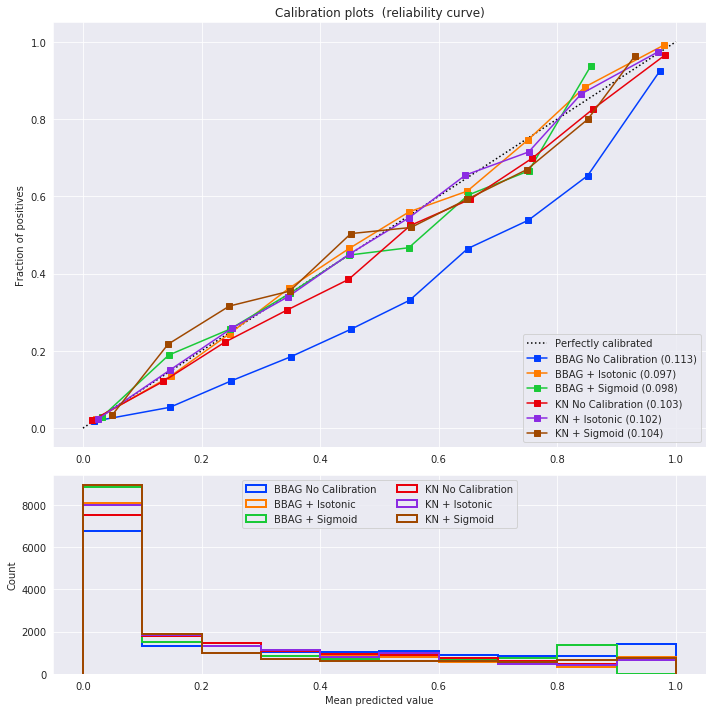

In [137]:
names = ['BBAG', 'KN']
tuned_models_3 = load_return_pipelines(names)

plot_calibration_curve(tuned_models_3, 1)
plt.show()

In [ ]:
names = ['RF', 'BNB']
tuned_models_4 = load_return_pipelines(names)

plot_calibration_curve(tuned_models_4, 1)
plt.show()

RF:
	Brier: 0.099
	Precision: 0.745
	Recall: 0.593
	Accuracy: 0.856

RF:
	Brier: 0.098
	Precision: 0.757
	Recall: 0.584
	Accuracy: 0.857

RF:
	Brier: 0.100
	Precision: 0.755
	Recall: 0.591
	Accuracy: 0.858



ETC:
	Brier: 0.112
	Precision: 0.682
	Recall: 0.584
	Accuracy: 0.837

ETC:
	Brier: 0.107
	Precision: 0.725
	Recall: 0.551
	Accuracy: 0.845

ETC:
	Brier: 0.109
	Precision: 0.721
	Recall: 0.553
	Accuracy: 0.844

Saved pipeline to: ETC_calibrated_pipe.joblib.dat
BAG:
	Brier: 0.096
	Precision: 0.761
	Recall: 0.615
	Accuracy: 0.863

BAG:
	Brier: 0.095
	Precision: 0.761
	Recall: 0.614
	Accuracy: 0.863

BAG:
	Brier: 0.097
	Precision: 0.761
	Recall: 0.616
	Accuracy: 0.864

Saved pipeline to: BAG_calibrated_pipe.joblib.dat


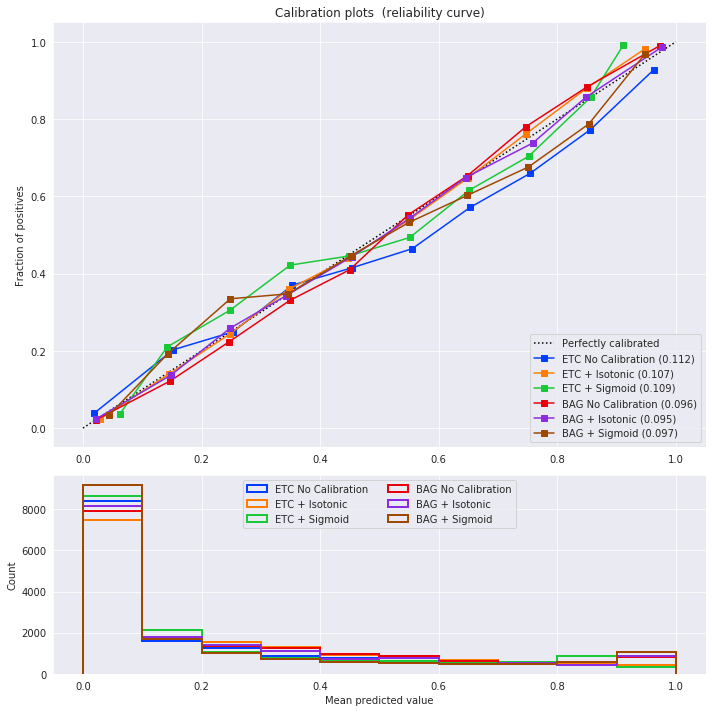

In [26]:
names = ['ETC', 'BAG']
tuned_models_5 = load_return_pipelines(names)

plot_calibration_curve(tuned_models_5, 1)
plt.show()

GBM:
	Brier: 0.091
	Precision: 0.757
	Recall: 0.658
	Accuracy: 0.869

GBM:
	Brier: 0.090
	Precision: 0.775
	Recall: 0.646
	Accuracy: 0.872

GBM:
	Brier: 0.090
	Precision: 0.775
	Recall: 0.643
	Accuracy: 0.872

Saved pipeline to: GBM_calibrated_pipe.joblib.dat
XGB:
	Brier: 0.089
	Precision: 0.769
	Recall: 0.649
	Accuracy: 0.871

XGB:
	Brier: 0.089
	Precision: 0.779
	Recall: 0.640
	Accuracy: 0.872

XGB:
	Brier: 0.091
	Precision: 0.779
	Recall: 0.644
	Accuracy: 0.873

Saved pipeline to: XGB_calibrated_pipe.joblib.dat


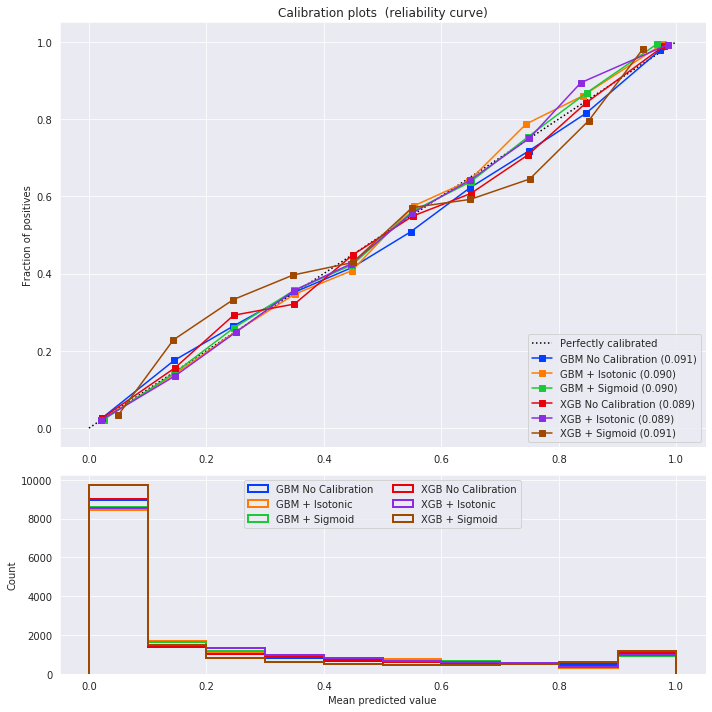

In [33]:
names = ['GBM', 'XGB']
tuned_models_6 = load_return_pipelines(names)

plot_calibration_curve(tuned_models_6, 1)
plt.show()

In [14]:
# load tuned models
tuned_calibr_mod_names = [
    'GNB_calibrated', 'BNB_calibrated', 'CART_calibrated', 'LR_calibrated', 'BAG_calibrated', 
    'KN_calibrated', 'GBM_calibrated', 'ETC_calibrated', 'XGB_calibrated', 'SVC_calibrated'
]

tuned_calibr_mod_pipes = load_return_pipelines(tuned_calibr_mod_names)

In [43]:
_, _ = result(s['SVC']['SVC_calibrated'], test_score=True)

Test accuracy: 0.8522


In [16]:
_, _ = result(tuned_calibr_mod_pipes, test_score=True)

>BBAG (test accuracy): 0.8309
>GNB_calibrated (test accuracy): 0.8082
>BNB_calibrated (test accuracy): 0.8282
>CART_calibrated (test accuracy): 0.8559
>LR_calibrated (test accuracy): 0.8508
>BAG_calibrated (test accuracy): 0.8630
>KN_calibrated (test accuracy): 0.8509
>RF (test accuracy): 0.8559
>GBM_calibrated (test accuracy): 0.8716
>ETC_calibrated (test accuracy): 0.8447
>XGB_calibrated (test accuracy): 0.8720


In [18]:
_, _ = result(tuned_calibr_mod_pipes)

>ETC_calibrated 0.8471 (0.003)
>XGB_calibrated 0.8701 (0.004)
>SVC_calibrated 0.8508 (0.003)


In [ ]:
_, _ = result(tuned_calibr_mod_pipes)

>GNB_calibrated 0.8090 (0.003)
>BNB_calibrated 0.8267 (0.004)
>CART_calibrated 0.8544 (0.004)
>LR_calibrated 0.8504 (0.003)
>BAG_calibrated 0.8622 (0.004)
>KN_calibrated 0.8516 (0.003)
>GBM_calibrated 0.8683 (0.004)


In [17]:
# load tuned models
tuned_mod_names = [
    'BBAG', 'GNB', 'BNB', 'CART', 'LR', 'BAG', 
    'KN', 'RF', 'GBM', 'ETC', 'XGB', 'SVC'
]

tuned_mod_pipes = load_return_pipelines(tuned_mod_names)
_, _ = result(tuned_mod_pipes, test_score=True)

>BBAG (test accuracy): 0.8309
>GNB (test accuracy): 0.7888
>BNB (test accuracy): 0.7716
>CART (test accuracy): 0.8551
>LR (test accuracy): 0.8512
>BAG (test accuracy): 0.8635
>KN (test accuracy): 0.8516
>RF (test accuracy): 0.8559
>GBM (test accuracy): 0.8692
>ETC (test accuracy): 0.8374
>XGB (test accuracy): 0.8710
>SVC (test accuracy): 0.8517


In [18]:
xgb = load_return_pipelines(['XGB', 'BNB'])
_, _ = result(xgb)

>XGB 0.8693 (0.003)
>BNB 0.7658 (0.005)


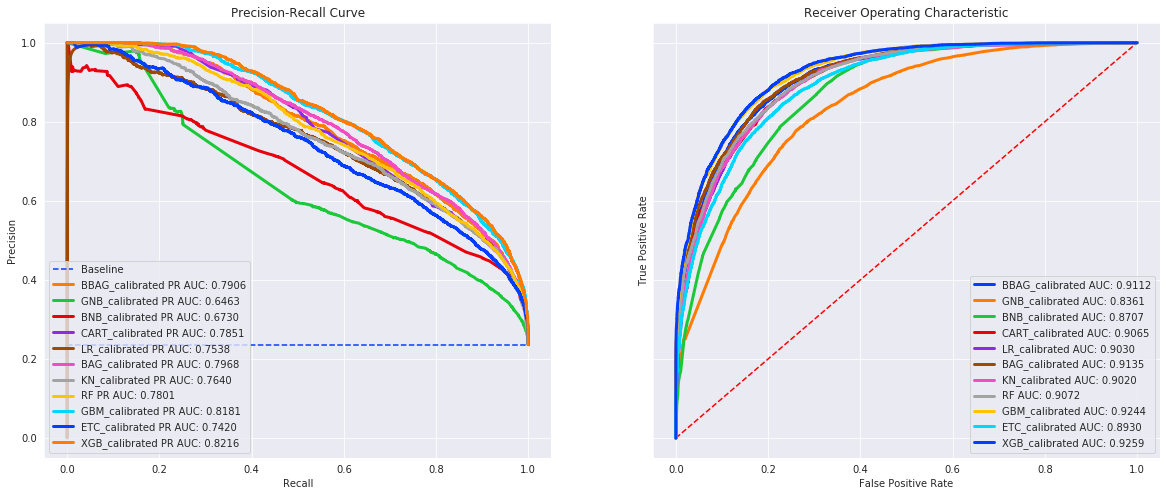

In [21]:
plot_pr_roc_curve(tuned_calibr_mod_pipes)

## Ensemble

this part includes:
- ensembling of tuned and calibrated models
- ensemble size optimization (choosing of less correlated models)
- soft & hard voting ensembles 
- averaged ensemble developing
- ensemble weights optimization (grid search & differential evolution)
- differential evolution with different 'tolerance' parameter

In [17]:
def get_fitted_pipes(models, trainX, trainy):
    fitted = []
    for model in models.items():
        f_mod = model[1].fit(trainX, trainy)
        fitted.append(f_mod)
    return fitted
# fit all models
members = get_fitted_pipes(tuned_calibr_mod_pipes, X_train, y_train)

In [243]:
# evaluate averaging ensemble all models
n_members = len(members)
weights = [1.0/n_members for _ in range(len(members))]
score = evaluate_ensemble(members, weights, X_test, y_test)
print('Equal Weights Score: %.3f' % score)

Equal Weights Score: 0.867


In [8]:
tuned_calibr_mod_names = [
    'GNB_calibrated', 'BNB_calibrated', 'CART_calibrated', 'LR_calibrated', 'BAG_calibrated', 
    'KN_calibrated', 'GBM_calibrated', 'ETC_calibrated', 'XGB_calibrated', 'SVC', 'BBAG', 'RF'
]
tuned_calibr_mod_pipes = load_return_pipelines(tuned_calibr_mod_names)

In [9]:
# corellation between models
results = []
results = pd.DataFrame(results)

def correlation(models):
    for model in models.items():
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)
        results[model[0]] = y_pred
    return results

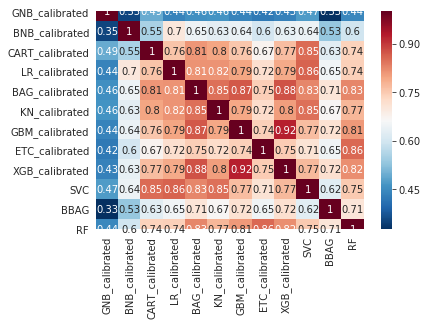

In [10]:
# correlation of tuned and calibrated models
results = correlation(tuned_calibr_mod_pipes)
pearsoncorr = results.corr(method='pearson')
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True)

#### Voting Ensemble (soft & hard voting)

In [12]:
# choose less correlated models
less_corr_names = ['BNB_calibrated', 'XGB_calibrated', 'GNB_calibrated', 'BBAG']
less_corr = load_return_pipelines(less_corr_names)

In [26]:
def get_voting(pipes, voting, weights=None):
    pipelines = []
    for pipe in pipes.items():
        pipelines.append(pipe)
    ensemble = VotingClassifier(estimators=pipelines, voting=voting, weights=weights)
    return ensemble

def get_pred_stack(pipes):
    pred_stack = {}
    for pipe in pipes.items():
        pred_stack[pipe[0]] = pipe[1]
    pred_stack['hard_voting'] = get_voting(pipes, voting='hard')
    pred_stack['soft_voting'] = get_voting(pipes, voting='soft')
    return pred_stack

voting = get_pred_stack(less_corr)
res, names = result(voting, test_score=True)

>BNB_calibrated (test accuracy): 0.8282
>XGB_calibrated (test accuracy): 0.8720
>GNB_calibrated (test accuracy): 0.8082
>BBAG (test accuracy): 0.8309
>hard_voting (test accuracy): 0.8575
>soft_voting (test accuracy): 0.8678


#### Equal Weights

In [13]:
# fit model on dataset
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict_proba(testX) for model in members]
    yhats = np.array(yhats)
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    result = np.argmax(summed, axis=1)
    return result

# make an ensemble prediction 
def ensemble_predictions(members, weights, Xval):
    # make predictions
    yhats = [model.predict_proba(Xval) for model in members]
    yhats = np.array(yhats)
    # weighted sum across ensemble members
    summed = np.tensordot(yhats, weights, axes=((0),(0)))
    # argmax across classes
    result = np.argmax(summed, axis=1)
    return result
 
# evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, Xtest, ytest):
    # make prediction
    yhat = ensemble_predictions(members, weights, Xtest)
    # calculate accuracy
    return accuracy_score(ytest, yhat)

In [ ]:
# split validation set from train data for weights optimization process
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=73)

In [63]:
# cv score of averaged ensemble
def get_weighted_ensemble(pipes, voting, weights=None):
    pipelines = []
    ensemble = {}
    for pipe in pipes.items():
        pipelines.append(pipe)
    ensemble['ensemble'] = VotingClassifier(estimators=pipelines, voting=voting, weights=weights)
    return ensemble

n_members = len(less_corr)
weights = [1.0/n_members for _ in range(len(less_corr))]
averaged_ensemble = get_weighted_ensemble(pipes=less_corr, voting='soft', weights=weights)
res, names = result(averaged_ensemble)

>ensemble 0.8613 (0.005)


In [ ]:
members = get_fitted_pipes(less_corr, X_train, y_train)

In [59]:
# test accuracy of averaging ensemble (equal weights)
n_members = len(members)
weights = [1.0/n_members for _ in range(len(members))]
score = evaluate_ensemble(members, weights, X_test, y_test)
print('Equal Weights Score: %.3f' % score)

Equal Weights Score: 0.863


In [20]:
# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    result = norm(weights, 1)
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    # return normalized vector (unit norm)
    return weights / result

# loss function for optimization process, designed to be minimized
def loss_function(weights, members, Xval, yval):
    # normalize weights
    normalized = normalize(weights)
    # calculate error rate
    return 1.0 - evaluate_ensemble(members, normalized, Xval, yval)

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return accuracy_score(testy, yhat)

# grid search weights
def grid_search(members, Xval, yval):
    # define weights to consider
    w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    best_score, best_weights = 0.0, None
    # iterate all possible combinations (cartesian product)
    for weights in product(w, repeat=len(members)):
        # skip if all weights are equal
        if len(set(weights)) == 1:
            continue
        # hack, normalize weight vector
        weights = normalize(weights)
        # evaluate weights
        score = evaluate_ensemble(members, weights, Xval, yval)
        if score > best_score:
            best_score, best_weights = score, weights
            print('>%s %.4f' % (best_weights, best_score))
    return list(best_weights)

#### Weights optimization

In [43]:
n_members = len(members)
# define bounds on each weight
bound_w = [(0.0, 1.0)  for _ in range(n_members)]
# arguments to the loss function
search_arg = (members, X_val, y_val)
# global optimization of ensemble weights
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-3)
# get the chosen weights
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)

Optimized Weights: [0.02242587 0.6517404  0.09060215 0.23523159]


In [44]:
# evaluate weights on test set (tol=1e-3)
score = evaluate_ensemble(members, weights, X_test, y_test)
print('Optimized Weights Score: %.4f' % score)

Optimized Weights Score: 0.8688


In [45]:
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7)
weights_2 = normalize(result['x'])
print('Optimized Weights: %s' % weights_2)

Optimized Weights: [0.02306937 0.6466212  0.09075747 0.23955196]


In [46]:
#weights_2 = [0.0846328, 0.0120125, 0.25095048, 0.65240422]
# evaluate weights on test set (tol=1e-7)
score_2 = evaluate_ensemble(members, weights_2, X_test, y_test)
print('Optimized Weights Score: %.4f' % score_2)

Optimized Weights Score: 0.8688


In [62]:
# cv score of weighted ensemble
weights = [0.0846328, 0.0120125, 0.25095048, 0.65240422]
weighted_ensemble = get_weighted_ensemble(pipes=less_corr, voting='soft', weights=weights)
res, names = result(weighted_ensemble)

>ensemble 0.8442 (0.004)


## Stacking

This part includes:
- 2-level stacking (with different final estimators)
- 3-layer stacking (with averaged or weighted weights in final layer)

In [1]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

In [254]:
train = get_data(path=train_set_path)
test = get_data(path=test_set_path, skiprows=[0])

X_train, y_train = split_enc_dataset(train)
X_test, y_test = split_enc_dataset(test)

In [119]:
# get a list of the base level model names
# instead of Balanced Bagging, SVC model was chosen  
lv_0 = ['GNB_calibrated', 'SVC', 'XGB_calibrated', 'BNB_calibrated']
lv_1 = LogisticRegression()

In [15]:
# building of stacking classifier with less correlated models as base estimators
def get_stacking(lv_0, lv_1):
    # define the base models
    lv_0_mod = []
    mod_0 = load_return_pipelines(lv_0)
    for name, model in mod_0.items():
        lv_0_mod.append((name, model))
    # define the stacking ensemble
    model = StackingClassifier(estimators=lv_0_mod, final_estimator=lv_1, cv=5)
    return model

In [17]:
# get a list of models to evaluate
def get_models(lv_0, lv_1):
    models = {}
    stack = get_stacking(lv_0, lv_1)
    models['stacking'] = stack
    return models

In [103]:
get_stacking(lv_0, lv_1)

StackingClassifier(cv=5,
                   estimators=[('GNB_calibrated',
                                Pipeline(steps=[('prepare',
                                                 Pipeline(steps=[('cleaning',
                                                                  FunctionTransformer(func=<function cleaning at 0x7feeec5938c0>)),
                                                                 ('add_drop',
                                                                  Pipeline(steps=[('attr_adder',
                                                                                   FunctionTransformer(func=<function add_new_feature at 0x7fef1bb91950>)),
                                                                                  ('attr_dropper',
                                                                                   FunctionTransformer(func=<function drop_features at 0x7...
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer(fill_value='Other',
                                                                                                                                  strategy='constant')),
                                                                                                                   ('cat_encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse=False))]),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7feed7fe69d0>)]))])),
                                                ('model',
                                                 CalibratedClassifierCV(base_estimator=BernoulliNB(),
                                                                        cv=5,
                                                                        method='isotonic'))]))],
                   final_estimator=LogisticRegression())

In [98]:
models = get_models(lv_0, lv_1)

In [96]:
## XGB - meta
_, _ = result(models, test_score=True)

>GNB_calibrated (test accuracy): 0.8082
>BBAG (test accuracy): 0.8309
>XGB_calibrated (test accuracy): 0.8720
>BNB_calibrated (test accuracy): 0.8282
>stacking (test accuracy): 0.8714


In [118]:
# LR - meta
lv_0 = ['GNB_calibrated', 'BBAG', 'XGB_calibrated', 'BNB_calibrated']
lv_1 = LogisticRegression()

lr = get_models(lv_0, lv_1)
_, _ = result(lr, test_score=True)

Test accuracy: 0.8720


In [20]:
lv_0 = ['GNB_calibrated', 'SVC', 'XGB_calibrated', 'BNB_calibrated']
lv_1 = XGBClassifier()

xgb = get_models(lv_0, lv_1)
_, _ = result(xgb, test_score=True)

Test accuracy: 0.8728


In [120]:
# get a list of the names of base level models XGB_calibrated
lv_0 = ['GNB_calibrated', 'SVC', 'XGB_calibrated', 'BNB_calibrated']
lv_1 = LogisticRegression()

lr = get_models(lv_0, lv_1)
_, _ = result(lr, test_score=True)

Test accuracy: 0.8728


In [21]:
# SVC - meta
lv_0 = ['GNB_calibrated', 'SVC', 'XGB_calibrated', 'BNB_calibrated']
lv_1 = SVC()

svc = get_models(lv_0, lv_1)
_, _ = result(svc, test_score=True)

Test accuracy: 0.8720


In [45]:
lv_0 = ['GNB_calibrated', 'SVC', 'XGB_calibrated', 'BNB_calibrated']
lv_1 = LogisticRegression()

lr = get_models(lv_0, lv_1)

results = list()
for name, model in lr.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    print('>%s %.4f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>stacking 0.8703 (0.003)


In [18]:
def get_stacking_2():
    # define the base models
    lv_0 = list()
    meta = dict()
    
    lv_0_mod = load_return_pipelines(['GNB_calibrated', 'BNB_calibrated', 'XGB_calibrated', 'SVC'])
    
    for name, model in lv_0_mod.items():
        lv_0.append((name, model))
    
    lv_1 = SVC(probability=True)
    meta['svc'] = StackingClassifier(estimators=lv_0, final_estimator=lv_1, cv=5)
    
    lv_1 = XGBClassifier()
    meta['xgb'] = StackingClassifier(estimators=lv_0, final_estimator=lv_1, cv=5)
    
    lv_1 = LogisticRegression()
    meta['lr'] = StackingClassifier(estimators=lv_0, final_estimator=lv_1, cv=5)
    return meta

models = get_stacking_2()

In [20]:
# list of fitted pipelines (stacks of pipelines) for weights optimization and weighted ensemble evaluation
members = get_fitted_pipes(models, X_train, y_train)

In [36]:
models['xgb']

StackingClassifier(cv=5,
                   estimators=[('GNB_calibrated',
                                Pipeline(steps=[('prepare',
                                                 Pipeline(steps=[('cleaning',
                                                                  FunctionTransformer(func=<function cleaning at 0x7fb59dba95f0>)),
                                                                 ('add_drop',
                                                                  Pipeline(steps=[('attr_adder',
                                                                                   FunctionTransformer(func=<function add_new_feature at 0x7fb59dba9710>)),
                                                                                  ('attr_dropper',
                                                                                   FunctionTransformer(func=<function drop_features at 0x7...
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fb59dba4350>),
                                                                                                  ('cat_pipeline',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer(fill_value='Other',
                                                                                                                                  strategy='constant')),
                                                                                                                   ('cat_encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse=False))]),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fb59dba3c50>)]))])),
                                                ('SVC',
                                                 SVC(random_state=42))]))],
                   final_estimator=XGBClassifier())

In [127]:
# test accuracy of 3-layer stacking model with final averaging layer 
# 2 models on the second layer
n_mem = len(members)
weights = [1.0/n_mem for _ in range(len(members))]
scor = evaluate_ensemble(members, weights, X_test, y_test)
print('Equal Weights Score: %.4f' % scor)

Equal Weights Score: 0.8734


In [21]:
# test accuracy of 3-layer stacking model with final averaging layer 
# 3 models on the second layer
n_mem = len(members)
weights = [1.0/n_mem for _ in range(len(members))]
score = evaluate_ensemble(members, weights, X_test, y_test)
print('Equal Weights Score: %.4f' % score)

Equal Weights Score: 0.8728


In [57]:
# cross-validated accuracy of 3-layer stacking model with final averaging layer
def get_voting_dict(pipes, voting='soft', weights=None):
    pipelines = []
    ensemble = {}
    for pipe in pipes.items():
        pipelines.append(pipe)
    ensemble['averaged_voting'] = VotingClassifier(estimators=pipelines, voting=voting, weights=weights)
    return ensemble

models = get_stacking_2()
n_mem = len(members)
weights = [1.0/n_mem for _ in range(len(models))]
voting = get_voting_dict(pipes=models, voting='soft', weights=weights)
res, names = result(voting)

>averaged_voting 0.8693 (0.002)


In [24]:
# weights for 3rd weghting layer of 3-layer stacking model
n_members = len(members)
bound_w = [(0.0, 1.0) for _ in range(n_members)]
# arguments to the loss function
search_arg = (members, X_val, y_val)
# global optimization of ensemble weights
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7)
# get the chosen weights
weights_st = normalize(result['x'])
print('Optimized Weights: %s' % weights_st)

Optimized Weights: [0.40757687 0.59242313]


In [25]:
# Optimized Weights: [0.77073235 0.22926765]
# test accuracy of 3-layer stacking model with final weighting layer 
score_st = evaluate_ensemble(members, weights_st, X_test, y_test)
print('Grid Search Score: %.4f' % score_st)

Grid Search Score: 0.8711


### Confidence intervals

interval = z * sqrt( (accuracy * (1 - accuracy)) / n)

- z (standard deviation) = 1.96 (for 95% confidence interval)
- accuracy (calculated classification accuracy)
- n (number of examples in dataset on which accuracy was measured)

In [26]:
X_test.shape

(16276, 15)

In [30]:
# binomial confidence interval
from math import sqrt

# 3-layer stacking 
interval = 1.96 * sqrt( (0.8734 * (1 - 0.8734)) / 16276)
lower = 0.8734 - interval
upper = 0.8734 + interval
print('The true classification accuracy of the model is likely between %.4f and %.4f.' % (lower, upper))

The true classification accuracy of the model is likely between 0.8683 and 0.8785.


In [32]:
# best model
interval = 1.96 * sqrt( (0.8720 * (1 - 0.8720)) / 16276)
lower = 0.8720 - interval
upper = 0.8720 + interval
print('The true classification accuracy of the model is likely between %.4f and %.4f.' % (lower, upper))

The true classification accuracy of the model is likely between 0.8669 and 0.8771.


# Interactive Results

In [9]:
train = get_data(path=train_set_path)
test = get_data(path=test_set_path, skiprows=[0])

X_train, y_train = split_enc_dataset(train)
X_test, y_test = split_enc_dataset(test)

In [10]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [11]:
def get_options(data, column_name):
    dat = cleaning(data)
    options = [_ for _ in data[str(column_name)].dropna().unique()]
    return options

In [12]:
def dropdown(name):
    options = get_options(X_train, name)
    widget = widgets.Dropdown(options=options, description=str(name));
    return widget
        
def inputfloatarea(name):
    widget = widgets.FloatText(
        value=0.0,
        description=str(name),
        disabled=False
    )
    return widget

def inputintarea(name):
    widget = widgets.IntText(
        value=0,
        description=str(name),
        disabled=False
    )
    return widget

def intslider(name):
    options = sorted(get_options(X_train, name))
    widget = widgets.IntSlider(
        value=0,
        min=options[0],
        max=options[-1],
        step=1,
        description=str(name),
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
    )
    return widget

In [13]:
age = intslider('age')
education_number = intslider('education_number')
hours_per_week = intslider('hours_per_week')
final_weight = inputintarea('final_weight')
capital_gain = inputfloatarea('capital_gain')
capital_loss = inputfloatarea('capital_loss')
work_class = dropdown('work_class')
education = dropdown('education')
marital_status = dropdown('marital_status')
occupation = dropdown('occupation')
relationship = dropdown('relationship')
race = dropdown('race')
sex = dropdown('sex')
country = dropdown('country')

In [19]:
pipe = load_return_pipelines(['XGB'])
fitted = pipe['XGB'].fit(X_train, y_train)

@interact_manual(fitted=fitted)
def show(
        age=age, work_class=work_class, final_weight=final_weight, education=education, 
        education_number=education_number, marital_status=marital_status, occupation=occupation,
        relationship=relationship, race=race, sex=sex, capital_gain=capital_gain, 
        capital_loss=capital_loss, hours_per_week=hours_per_week, country=country):
    
    test_data_num = [
        education_number, final_weight, age, 
        capital_gain, capital_loss, hours_per_week
    ]
    test_data_cat = [
        work_class, education, marital_status, 
        occupation, relationship, race, sex, country
    ] 
    
    name_col_1 = [
        'education_number', 'final_weight', 'age', 
        'capital_gain', 'capital_loss', 'hours_per_week'
    ]
    name_col_2 = [
        'work_class', 'education', 'marital_status', 'occupation',
        'relationship', 'race', 'sex', 'country'
    ]
    
    data1 = pd.DataFrame(np.array(test_data_num).reshape(1, 6), columns=name_col_1)
    data2 = pd.DataFrame(np.array(test_data_cat).reshape(1, 8), columns=name_col_2)
    data = pd.concat([data1, data2], sort=False, axis=1)   
    return fitted.predict(data)

interactive(children=(IntSlider(value=17, continuous_update=False, description='age', max=90, min=17), Dropdow…

In [47]:
X_test[50:55]

Age Work Class  Final Weight      Education  Education Number  \
50   18    Private         54440   Some-college                10   
51   39    Private        280215        HS-grad                 9   
52   21    Private        214399   Some-college                10   
53   22    Private         54164        HS-grad                 9   
54   38    Private        219446            9th                 5   

            Marital Status          Occupation    Relationship    Race  \
50           Never-married       Other-service       Own-child   White   
51                Divorced   Handlers-cleaners       Own-child   Black   
52           Never-married       Other-service       Own-child   White   
53           Never-married       Other-service   Not-in-family   White   
54   Married-spouse-absent     Exec-managerial   Not-in-family   White   

        Sex  Capital Gain  Capital Loss  Hours per Week         Country  
50     Male           0.0             0              20   United-States  
51     Male           0.0             0              40   United-States  
52   Female           0.0          1721              24   United-States  
53     Male       14084.0             0              60   United-States  
54     Male           0.0             0              54          Mexico

In [48]:
y_test[50:55]

array([0, 0, 0, 1, 0])